In [1]:
import time
import datetime
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import gc
from mu2etools import *
from mu2etools import wideband
import math

hep.style.use('ATLAS')
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"

In [2]:
def aging(x, A, r):
    return A*(1-r/100)**x

In [3]:
runs = [1720, 1721, 1722, 1723, 1724, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 2004, 2005, 2006, 2007, 2008, 2009, 2015, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
processor = wideband.DataProcessor(usexroot=True, treename='runSummary', runlist=runs, userunlist=True, remove=False)
filelist = processor.getFilelist(DATASET)
filelist = ["{}{}".format(i, ":runSummary") for i in filelist]

In [4]:
varlist = ['runNumber', 'subrunNumber', 'timestamp', 'PEsTemperatureCorrected',
           'calibConstantsTemperatureCorrected', 'FWHMsTemperatureCorrected', 'signalsTemperatureCorrected']
d = {}
for chan in range(128):
    d["SPEs_{0}".format(chan)] = []
    d["PEs_{0}".format(chan)] = []
    d["PEs_sigma_{0}".format(chan)] = []
    d["signals_{0}".format(chan)] = []
    d["time_{0}".format(chan)] = []
badchannels = []
    
for idx, filename in enumerate(filelist):
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="10MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['SPEsTemperatureCorrected'] = ak.mask(ar['calibConstantsTemperatureCorrected'], ar['calibConstantsTemperatureCorrected']>0)
            for chan in range(64):
                if ar['timestamp'][0] > 0:
                    if ar['PEsTemperatureCorrected'][0,2,chan] > 0:
                        d["SPEs_{0}".format(chan+64)].append(ar['SPEsTemperatureCorrected'][0,2,chan])
                        d["PEs_{0}".format(chan+64)].append(ar['PEsTemperatureCorrected'][0,2,chan])
                        d["PEs_sigma_{0}".format(chan+64)].append(ar['FWHMsTemperatureCorrected'][0,2,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,2,chan])))
                        d["signals_{0}".format(chan+64)].append(ar['signalsTemperatureCorrected'][0,2,chan])
                        d["time_{0}".format(chan+64)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan+64)
                    if ar['PEsTemperatureCorrected'][0,1,chan] > 0:
                        d["SPEs_{0}".format(chan)].append(ar['SPEsTemperatureCorrected'][0,1,chan])
                        d["PEs_{0}".format(chan)].append(ar['PEsTemperatureCorrected'][0,1,chan])
                        d["PEs_sigma_{0}".format(chan)].append(ar['FWHMsTemperatureCorrected'][0,1,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,1,chan])))
                        d["signals_{0}".format(chan)].append(ar['signalsTemperatureCorrected'][0,1,chan])
                        d["time_{0}".format(chan)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan)

for chan in range(128):
    if chan in badchannels:
        continue
    else:
        d["time_{0}".format(chan)] = np.array(d["time_{0}".format(chan)])
        d["dt_{0}".format(chan)] = (d["time_{0}".format(chan)] - d["time_{0}".format(chan)][0])/(60*60*24*365.25)
        d["SPEs_{0}".format(chan)] = np.array(d["SPEs_{0}".format(chan)])
        d["PEs_{0}".format(chan)] = np.array(d["PEs_{0}".format(chan)])
        d["signals_{0}".format(chan)] = np.array(d["signals_{0}".format(chan)])
        d["PEs_sigma_{0}".format(chan)] = np.array(d["PEs_sigma_{0}".format(chan)])

/tmp/ipykernel_14488/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x


high aging 30


/tmp/ipykernel_14488/1243029372.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1) = plt.subplots(1, 2)


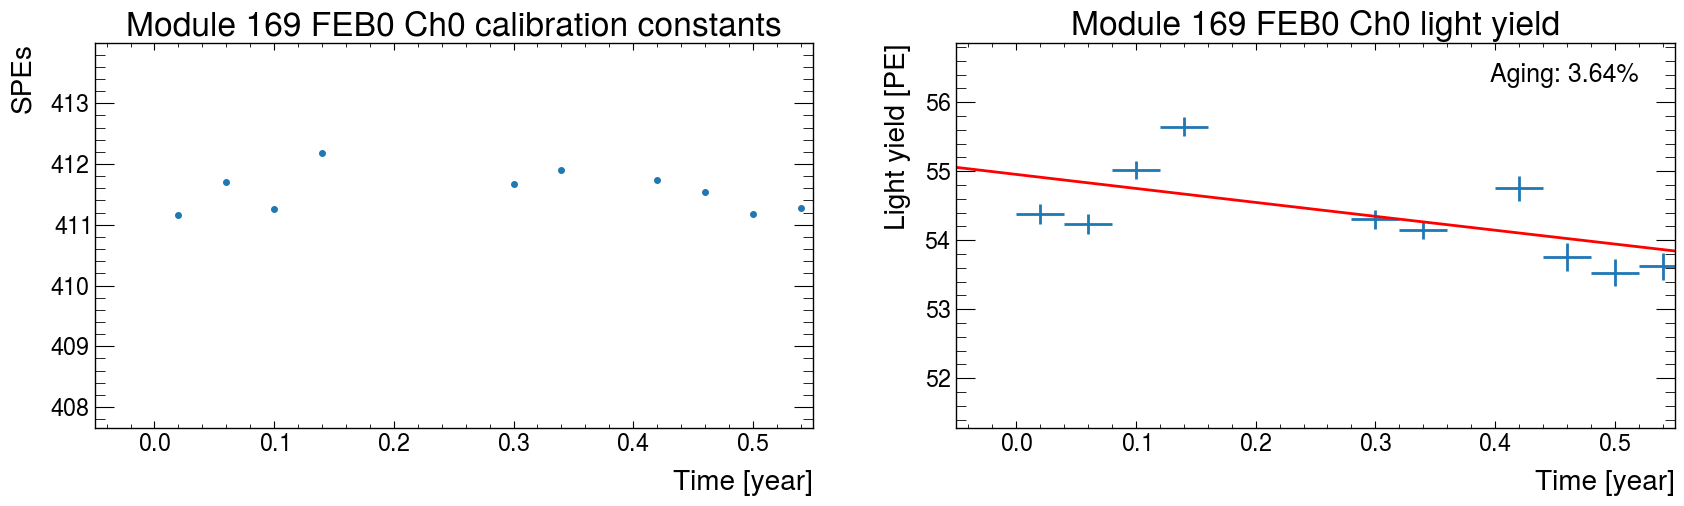

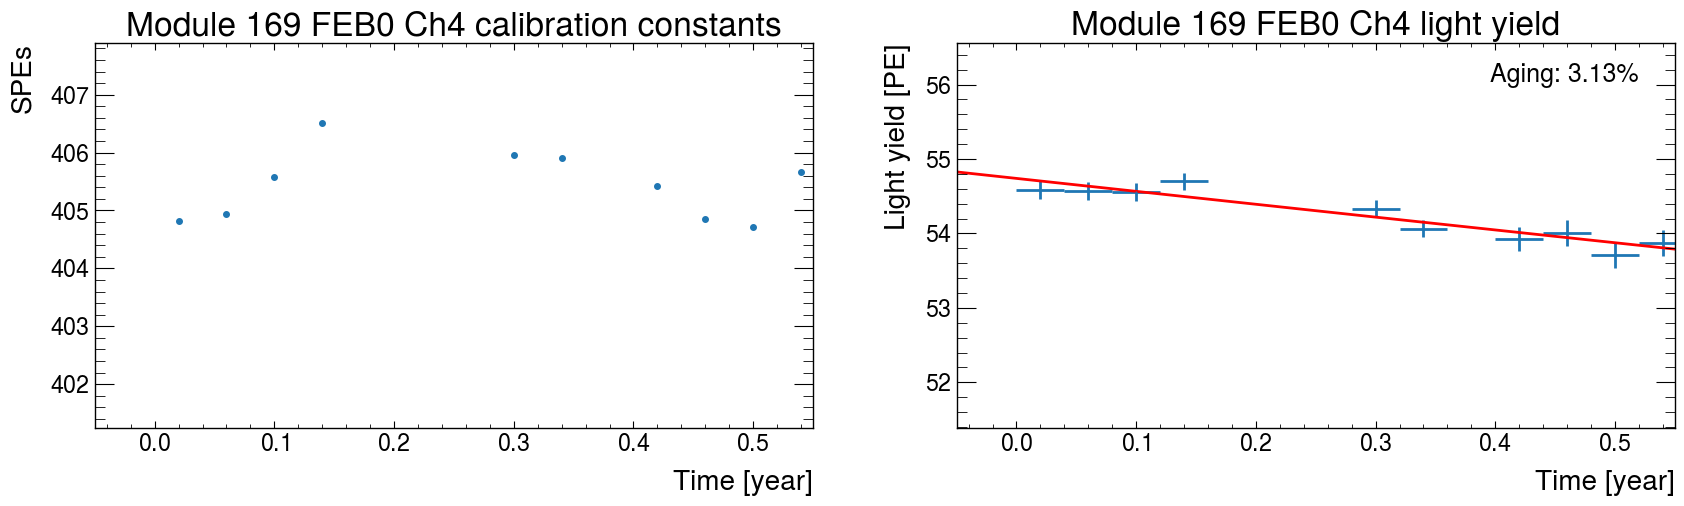

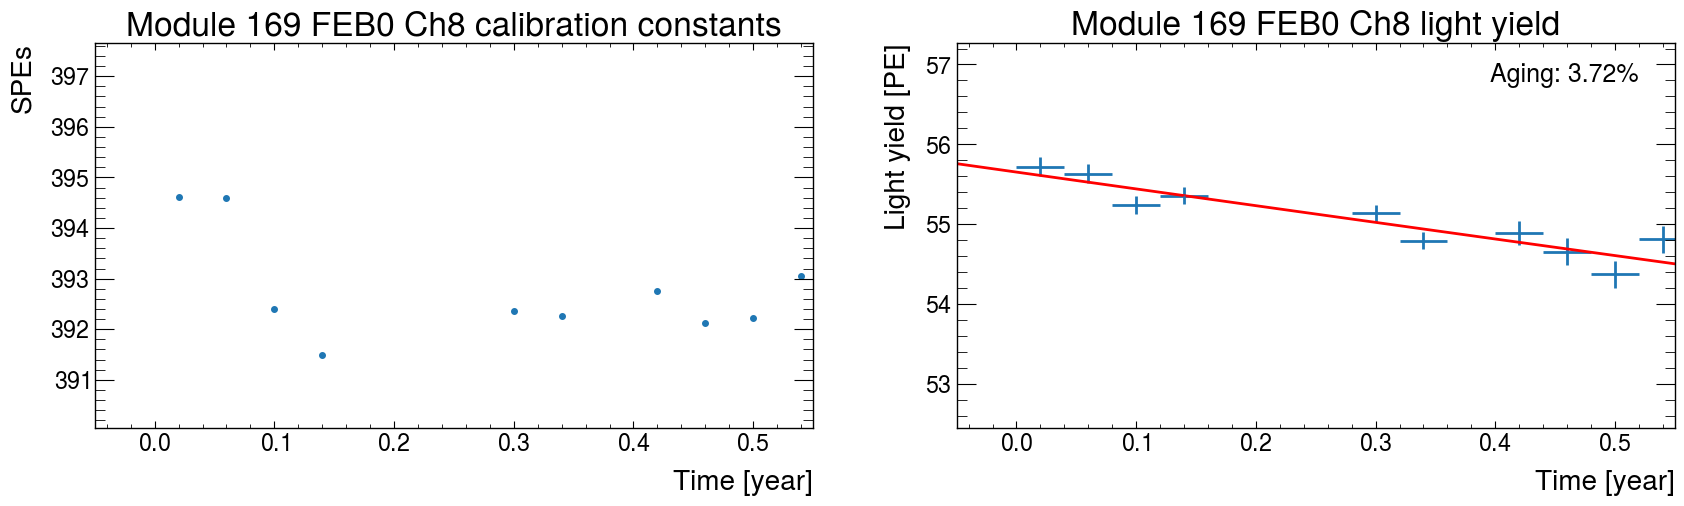

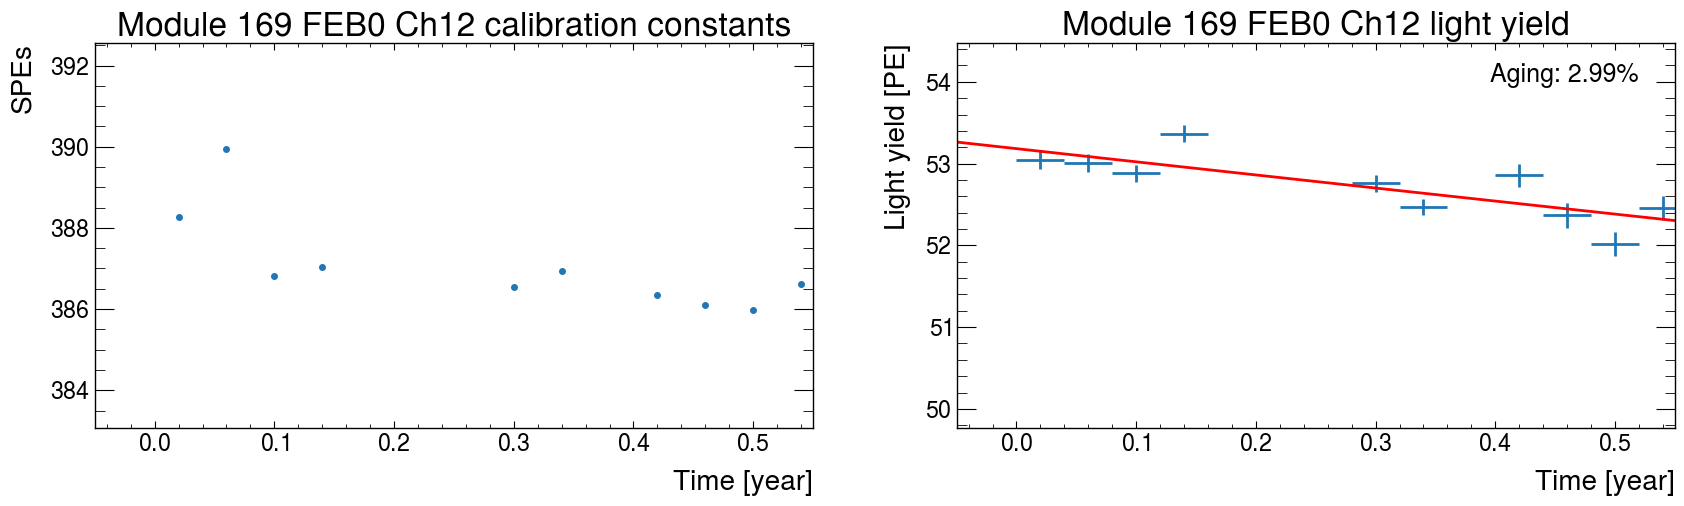

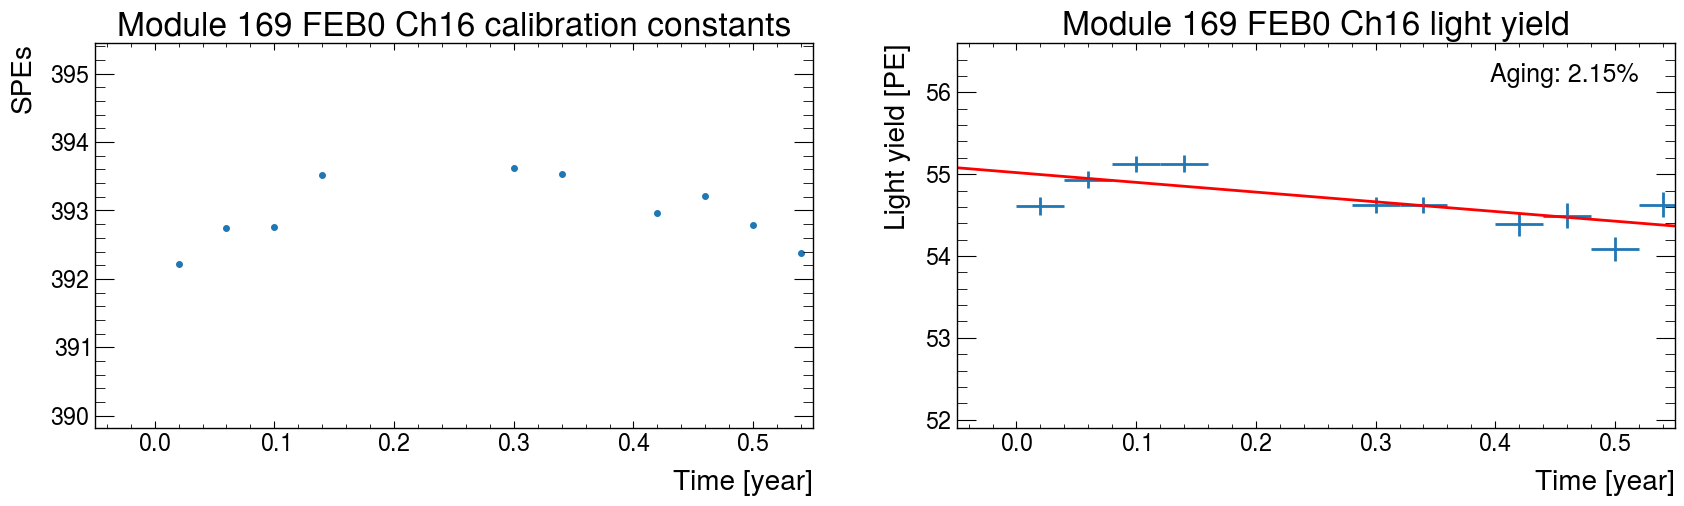

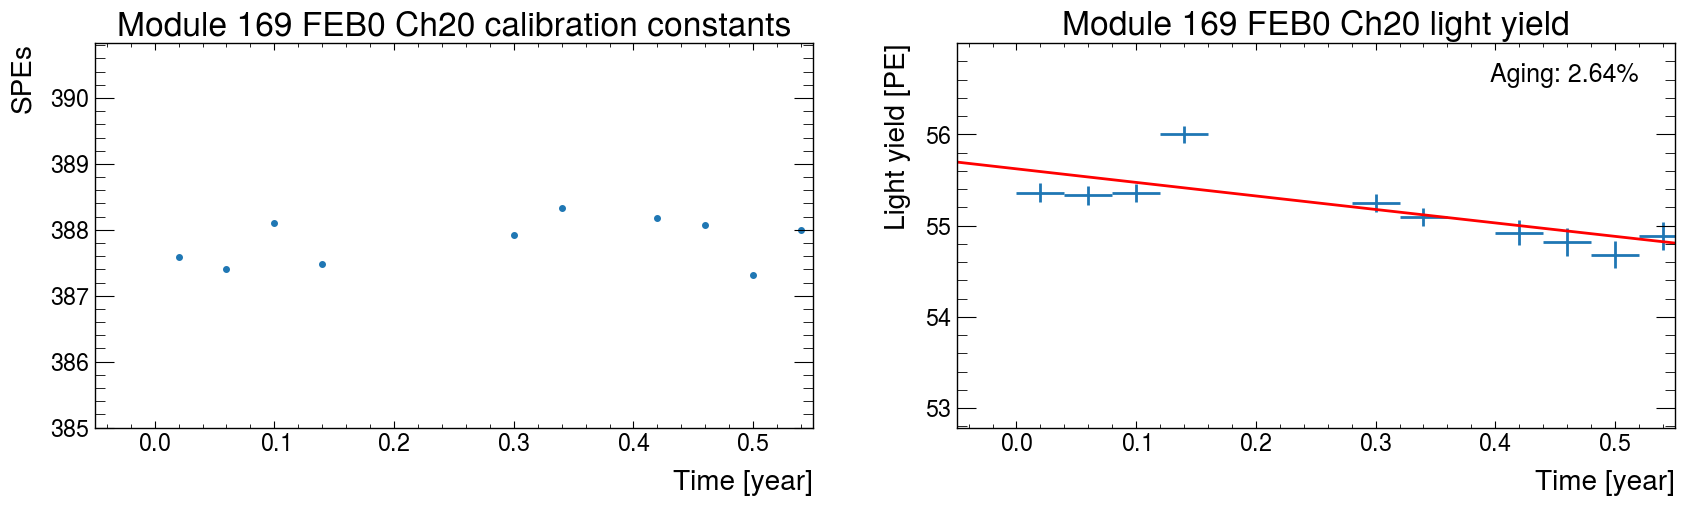

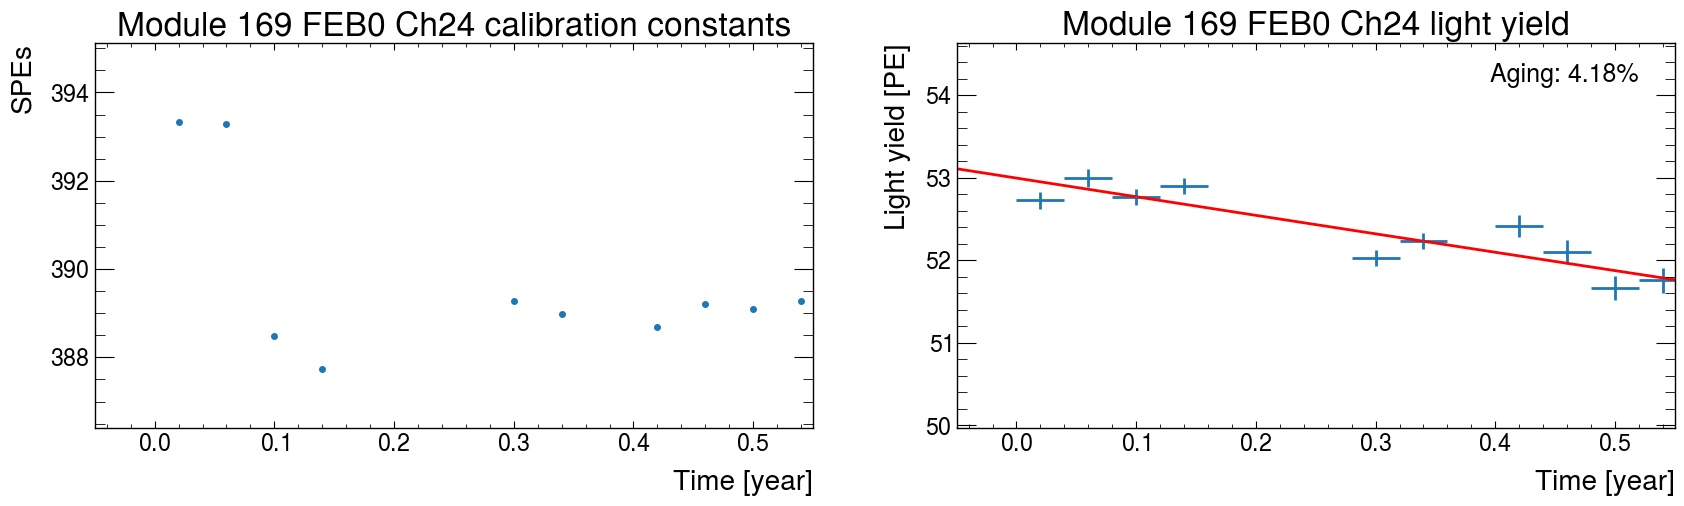

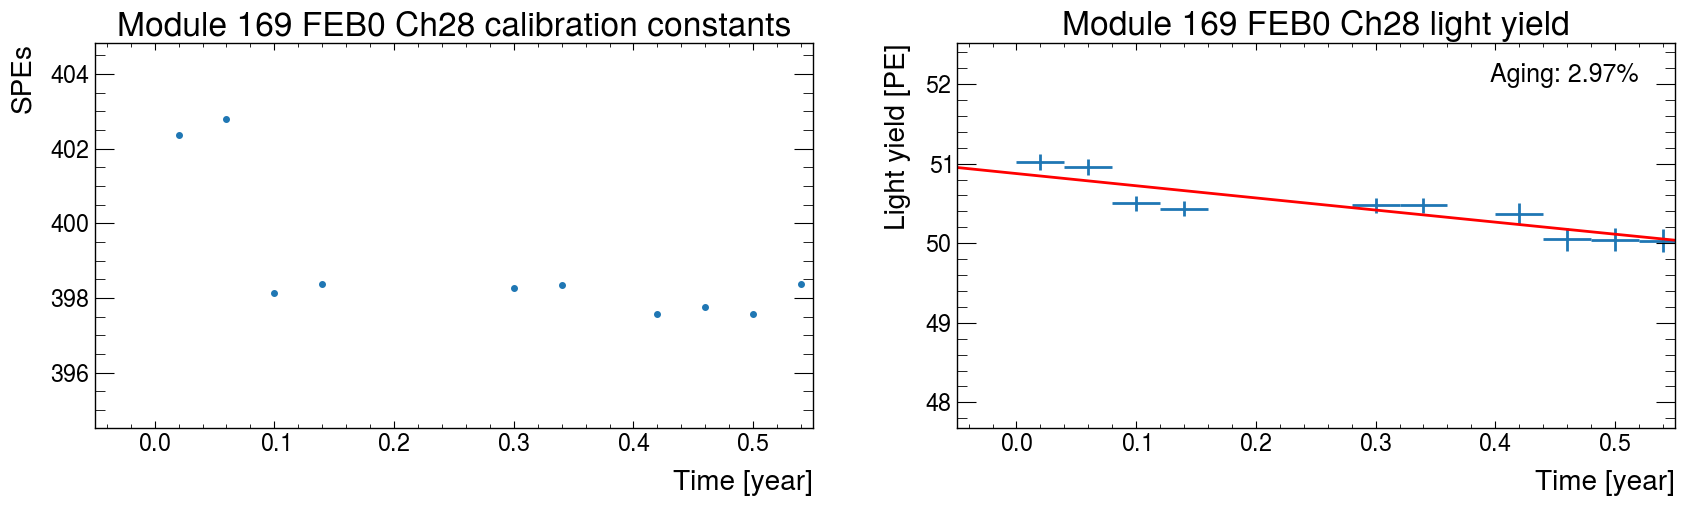

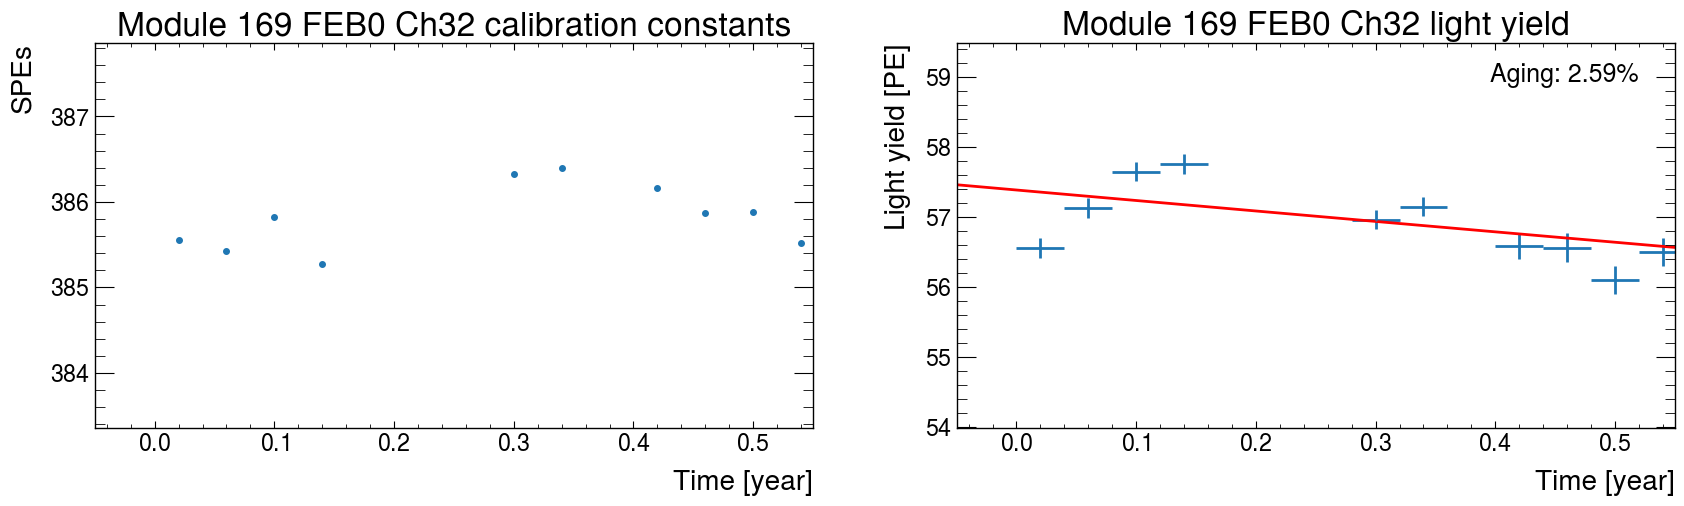

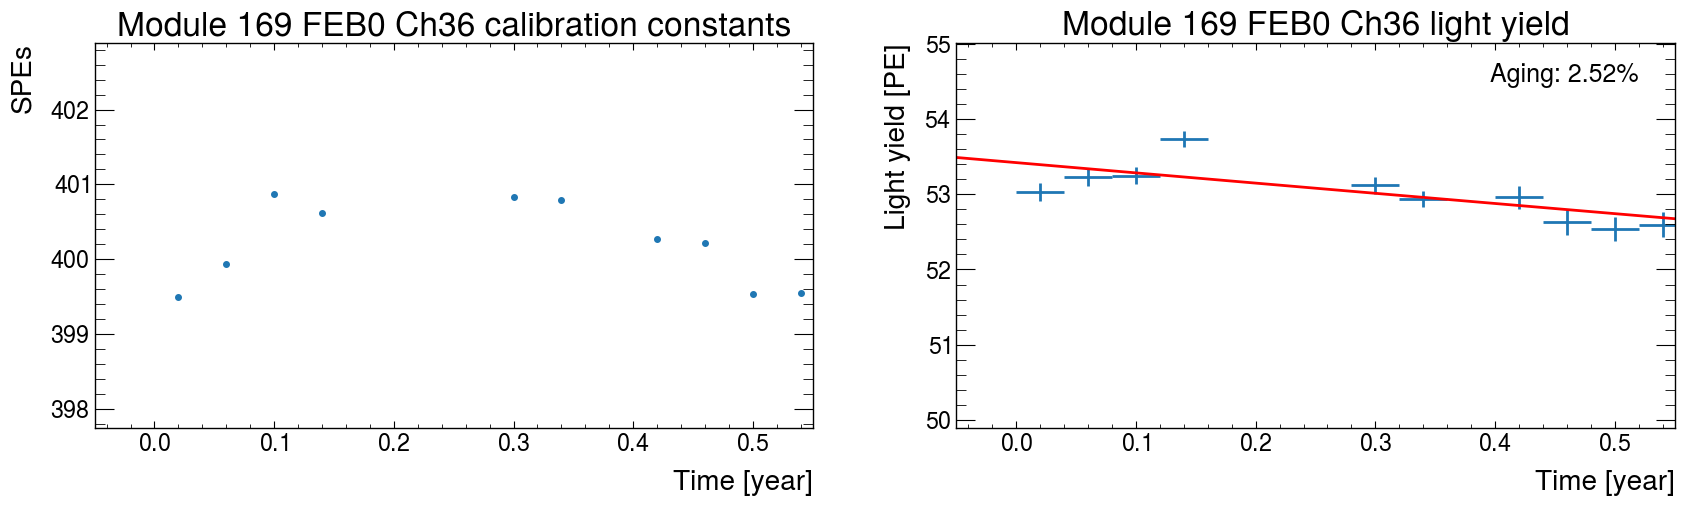

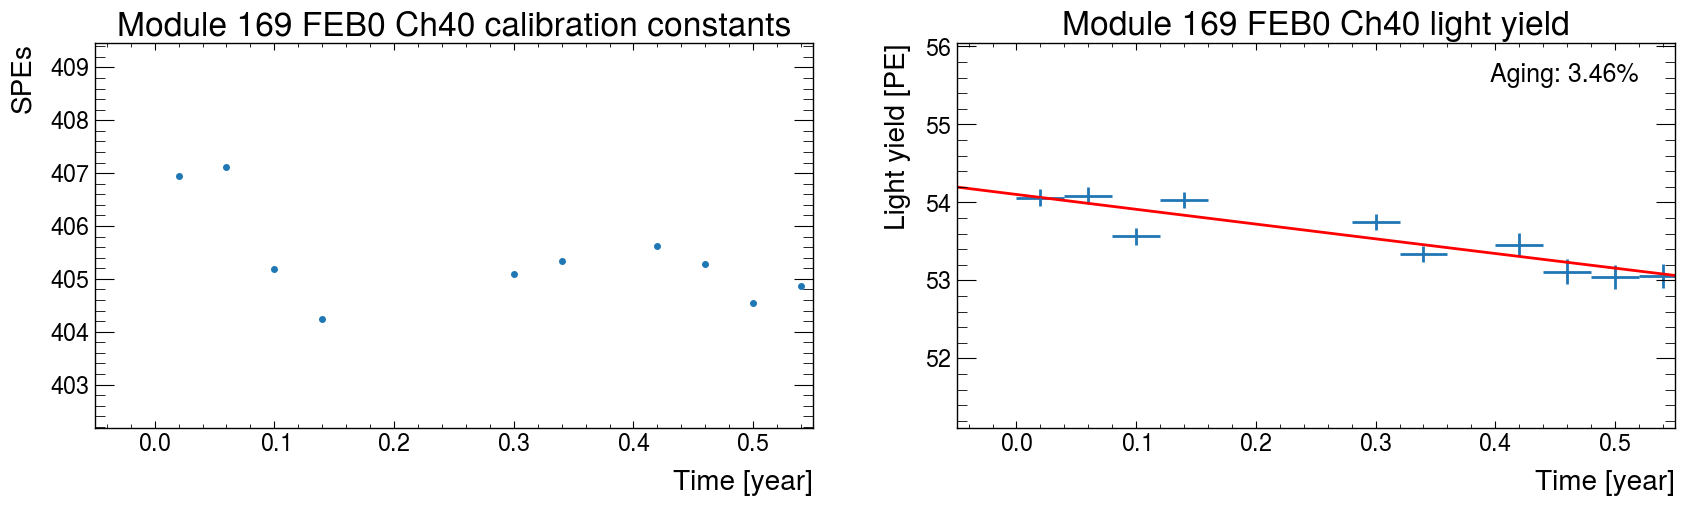

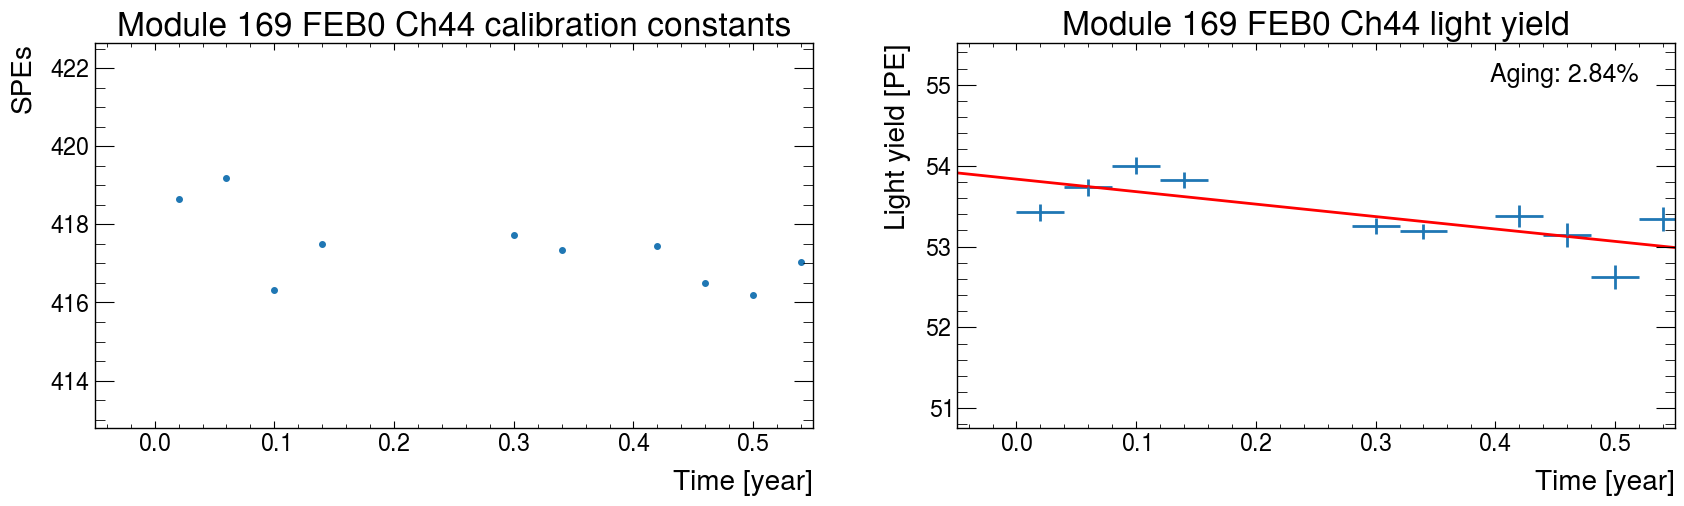

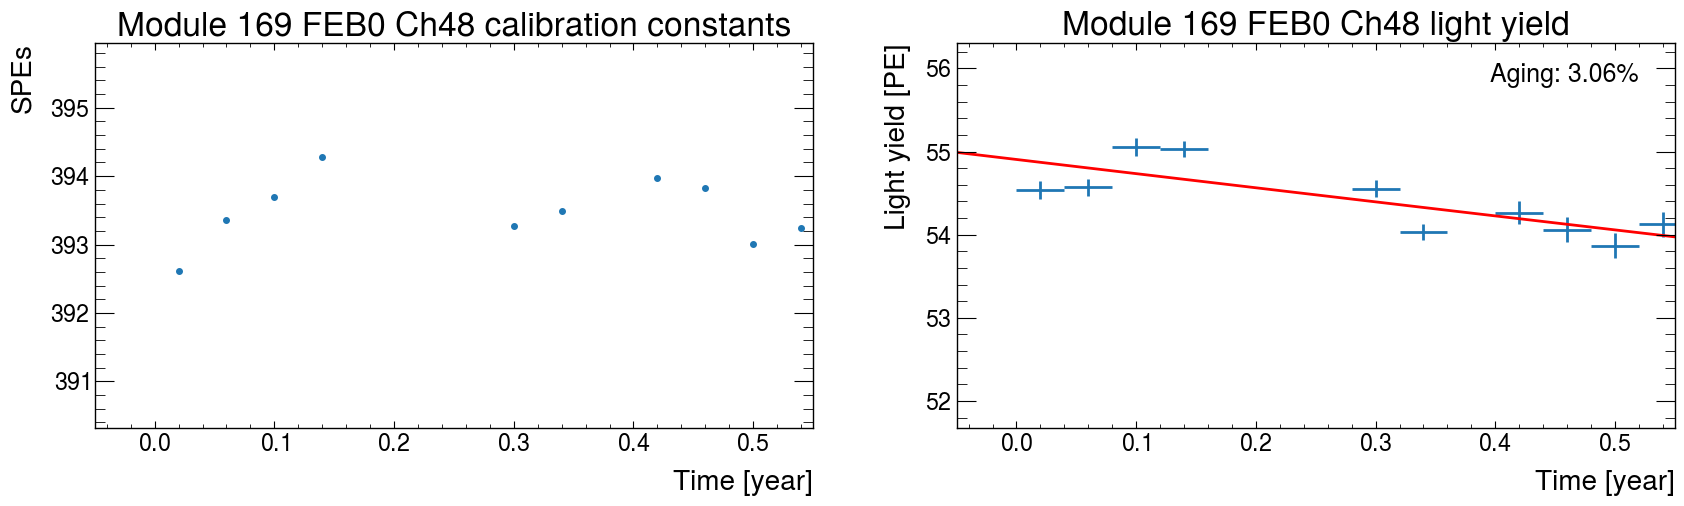

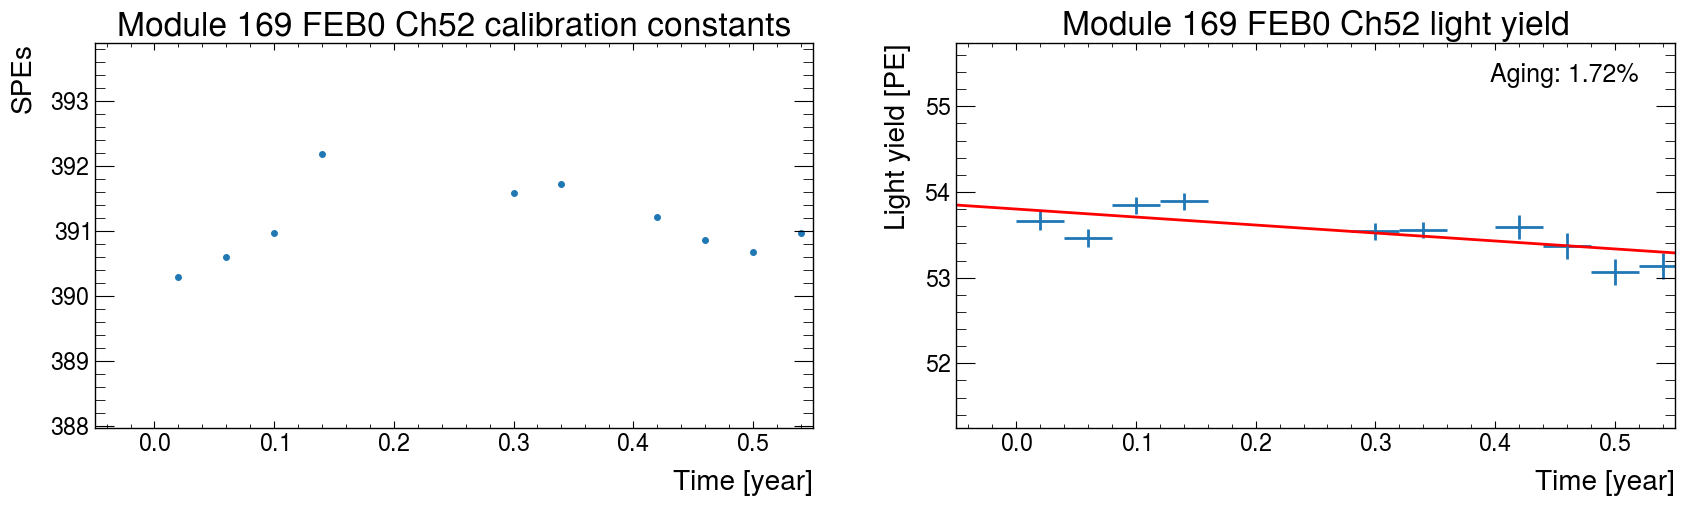

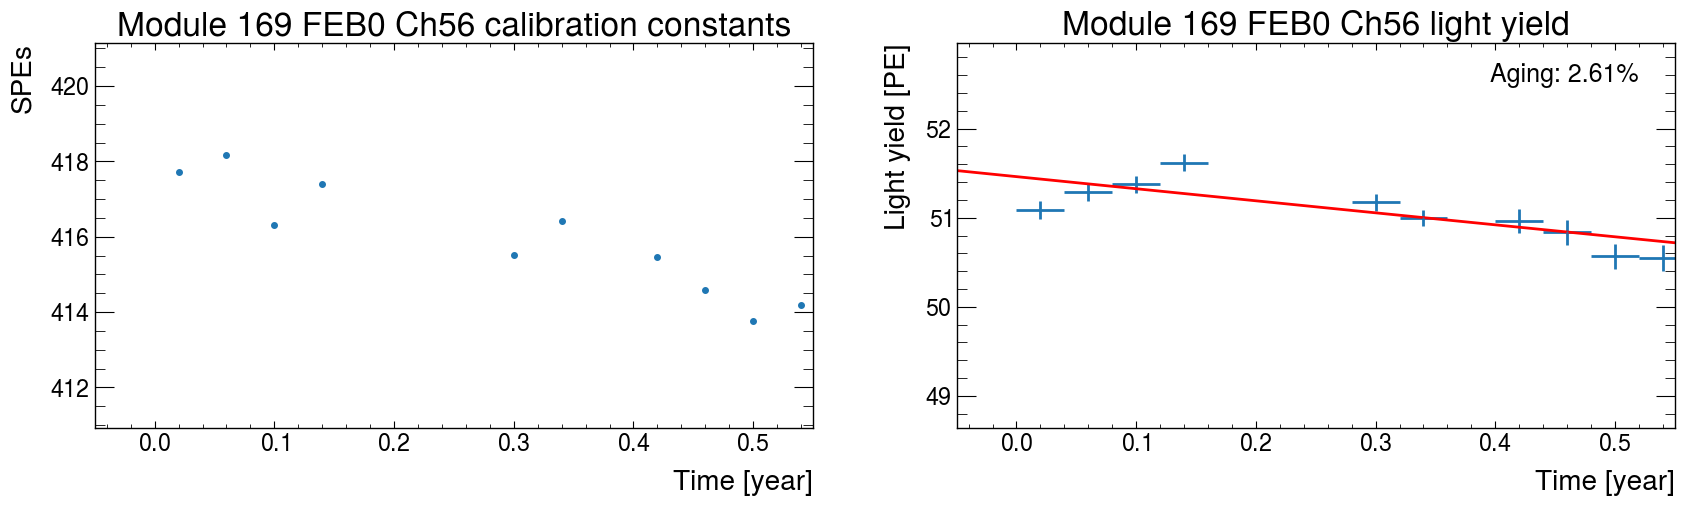

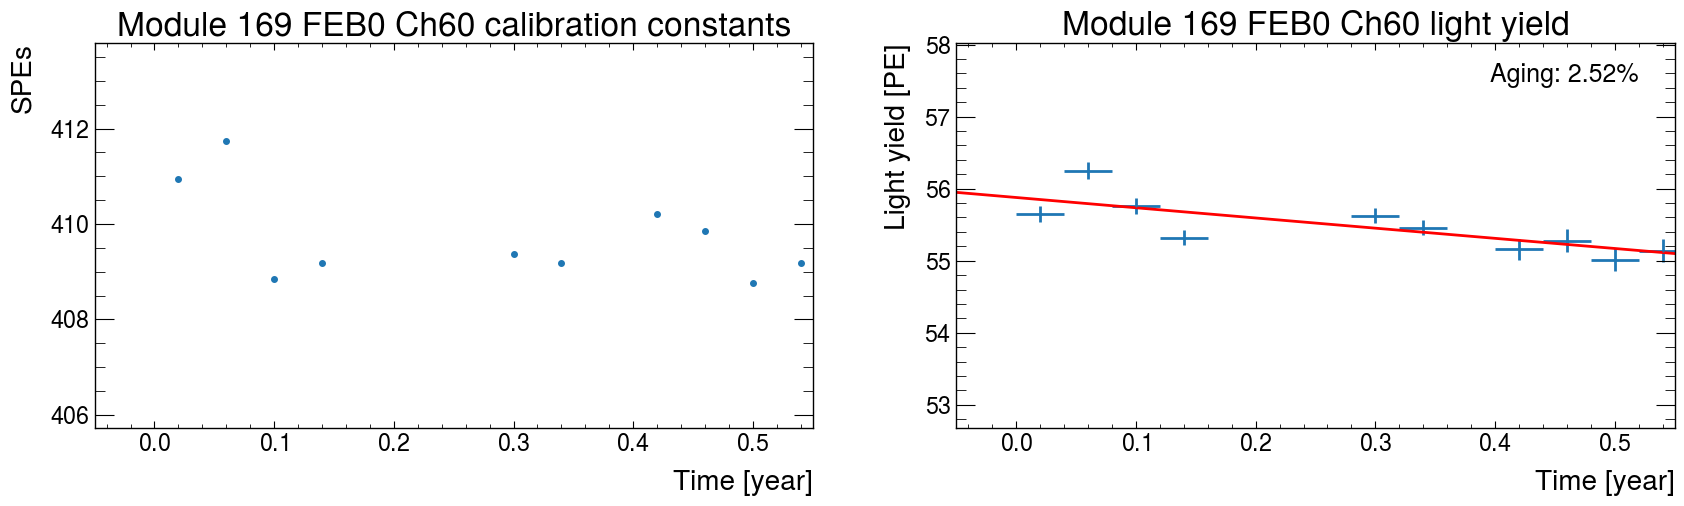

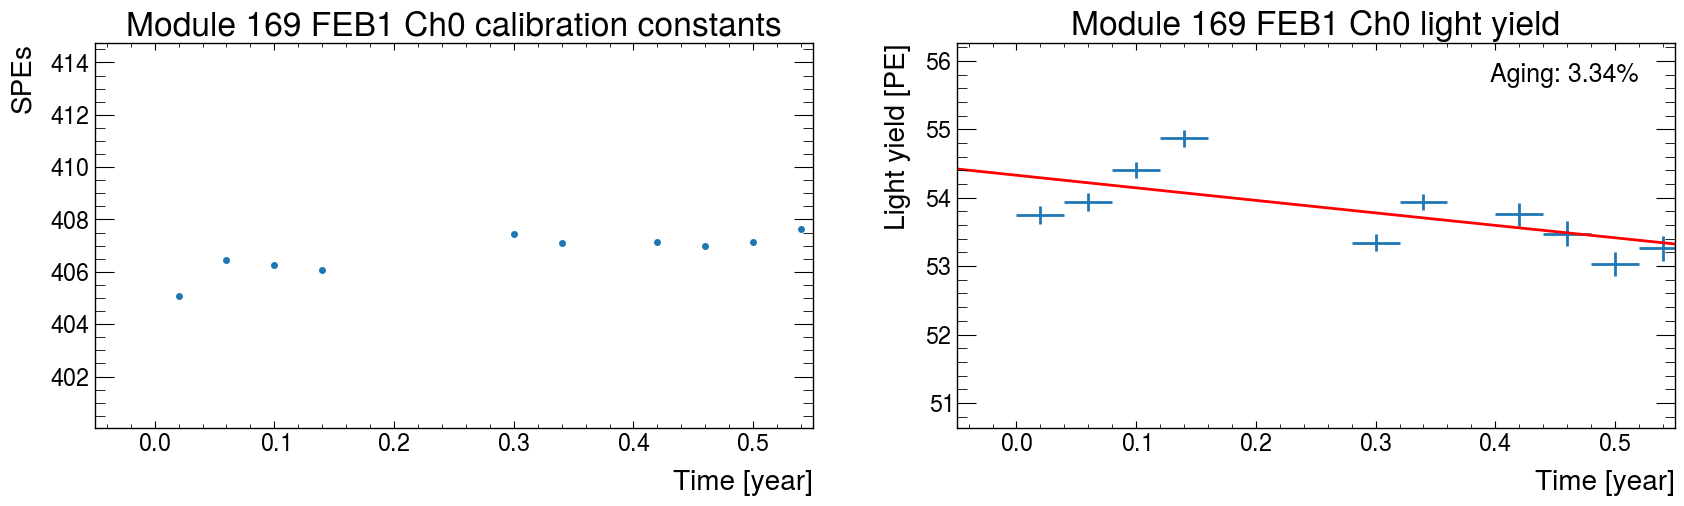

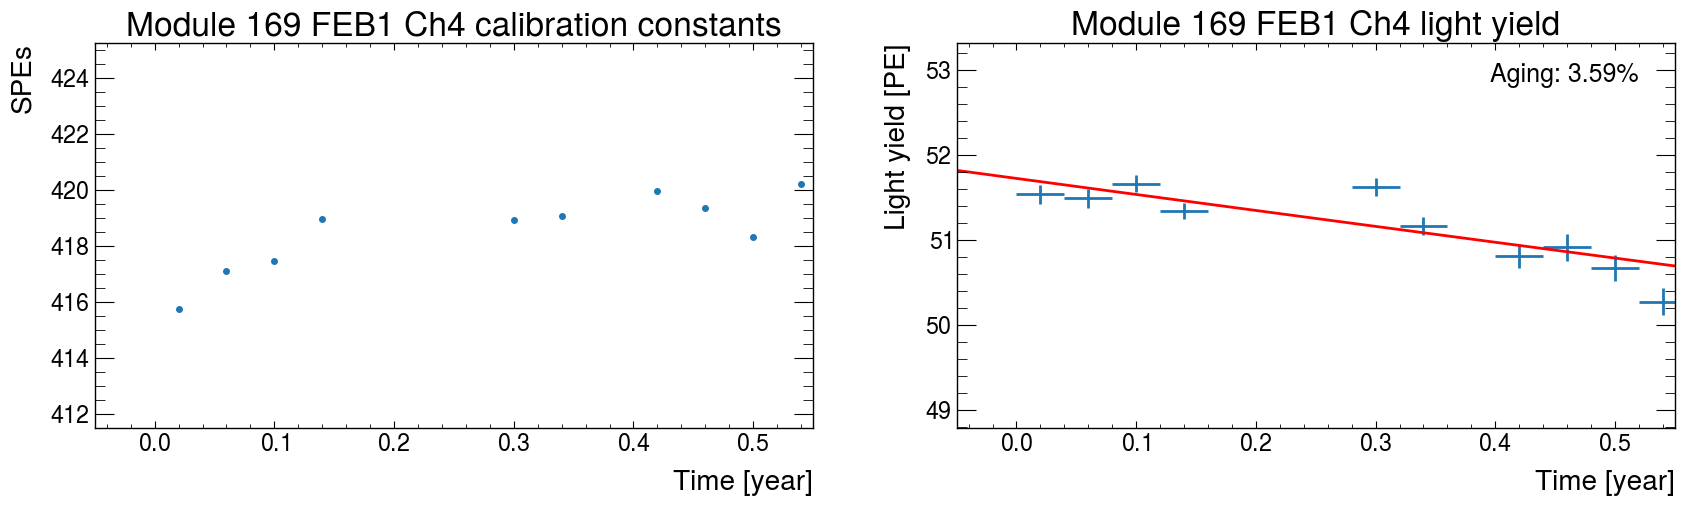

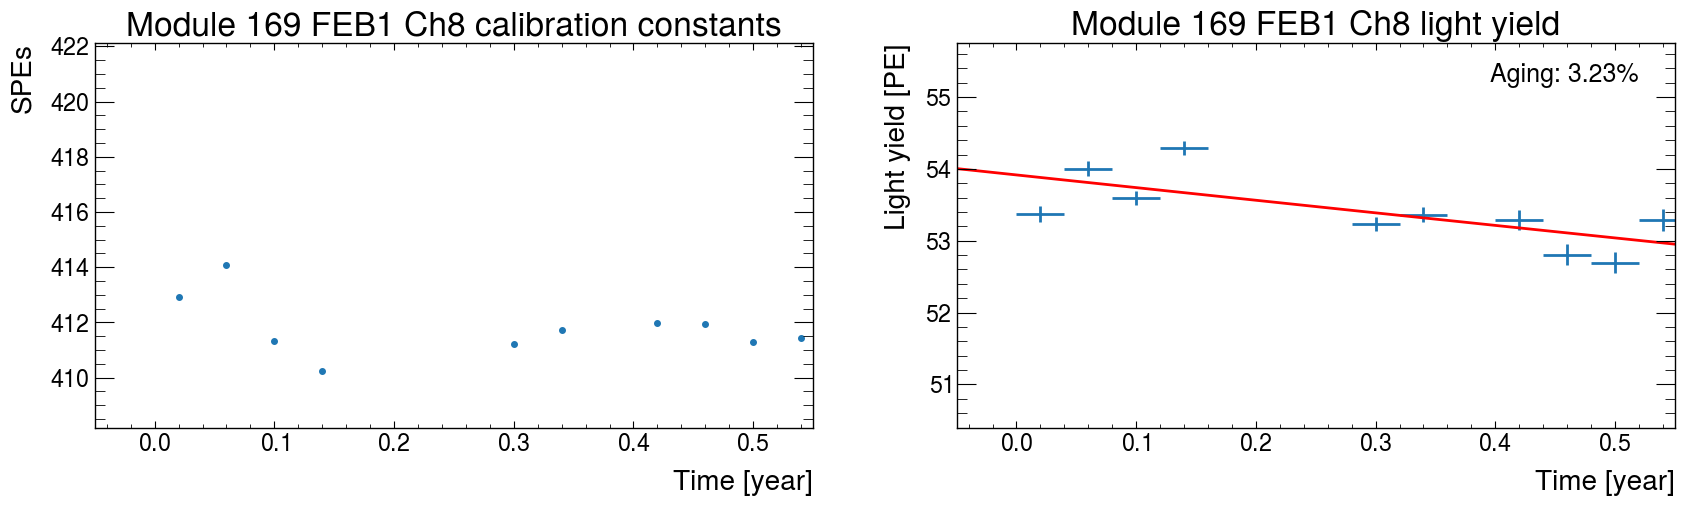

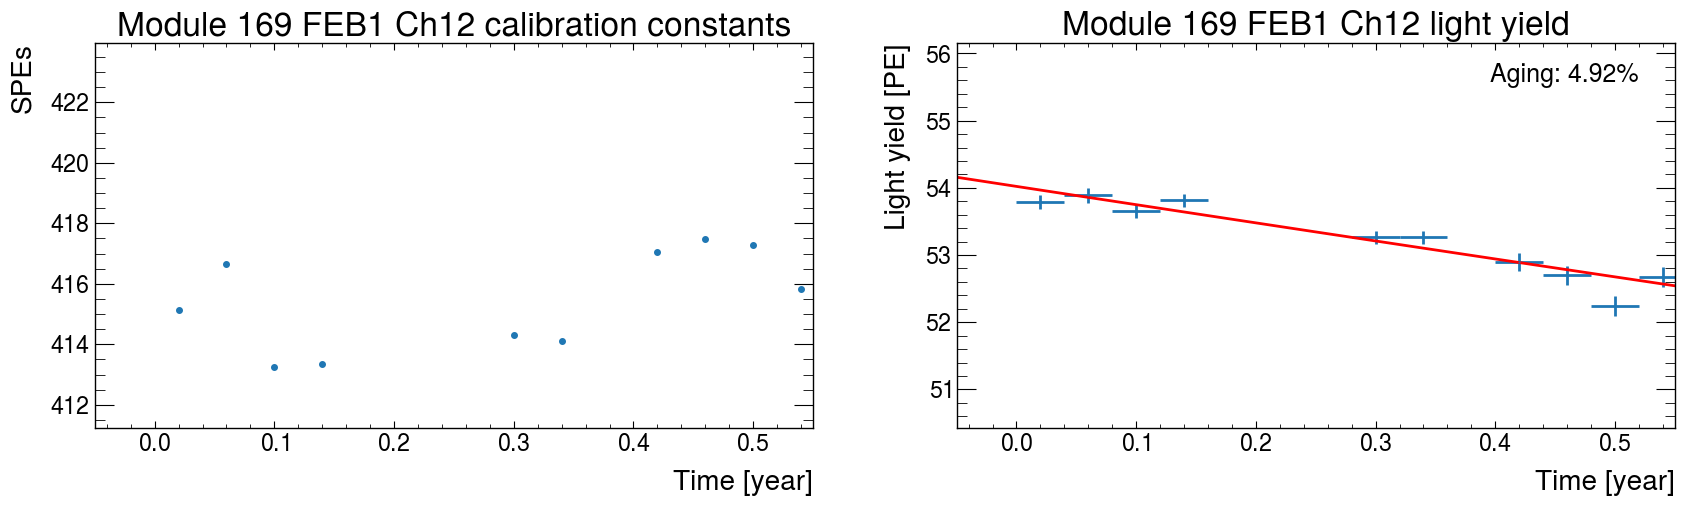

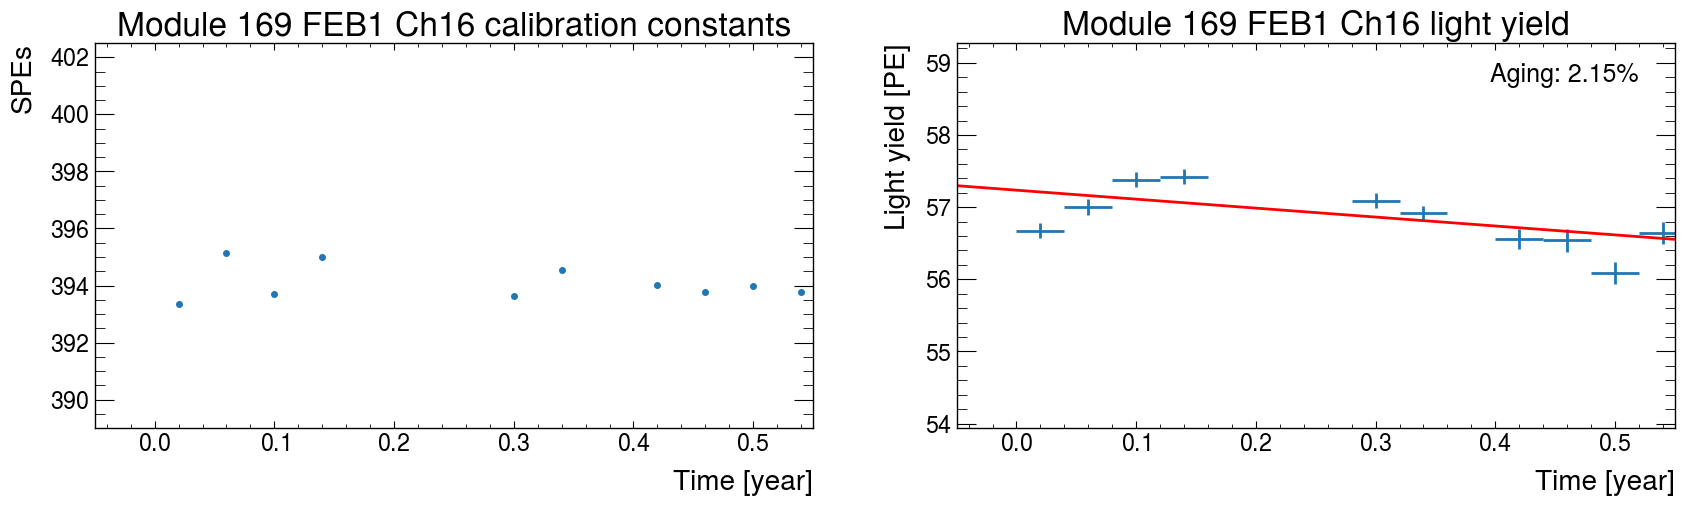

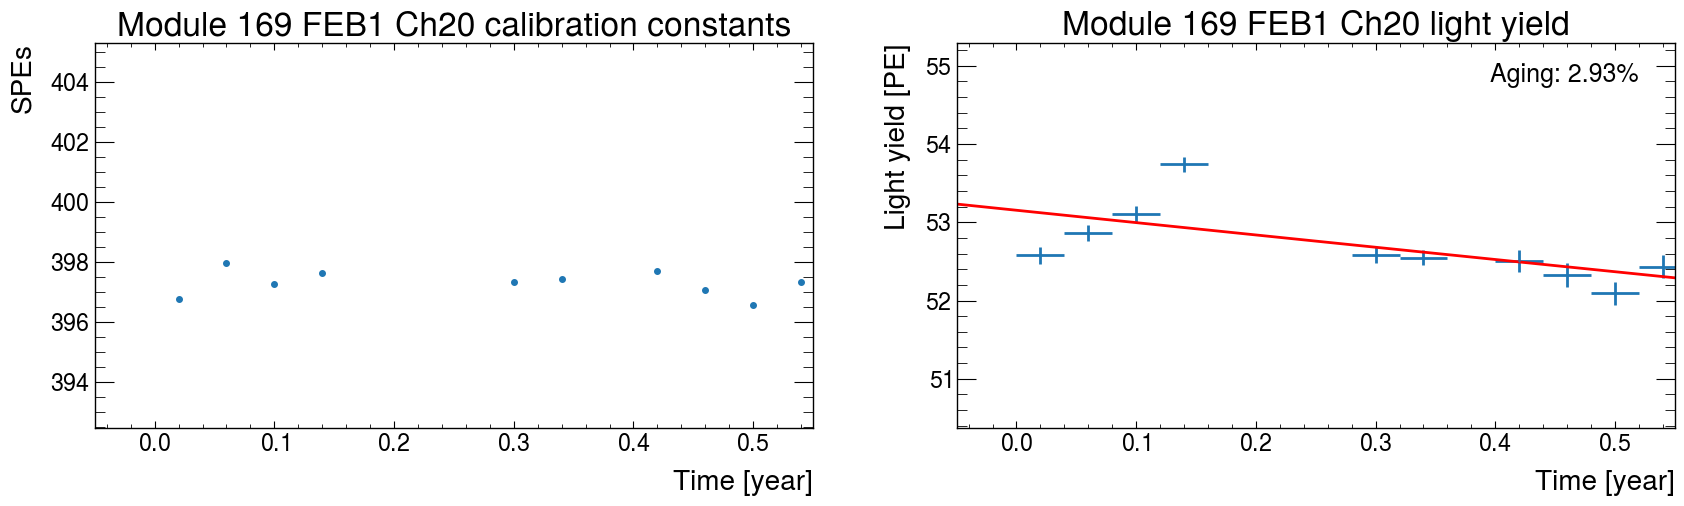

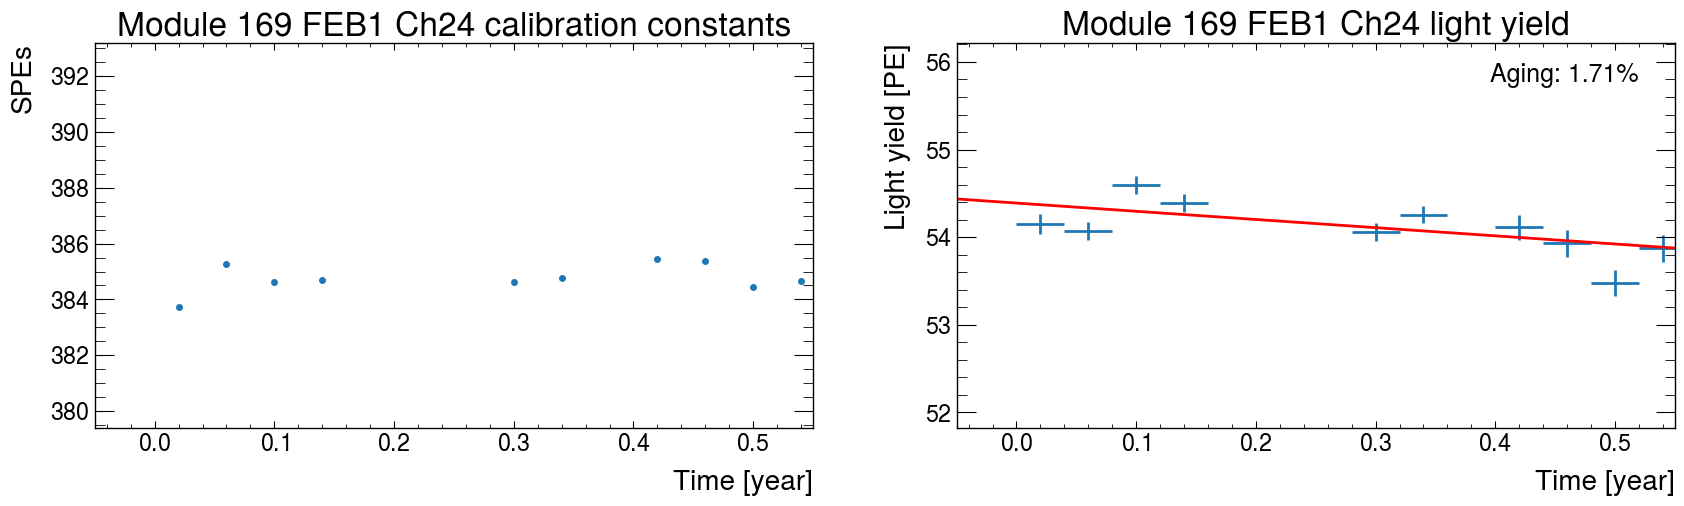

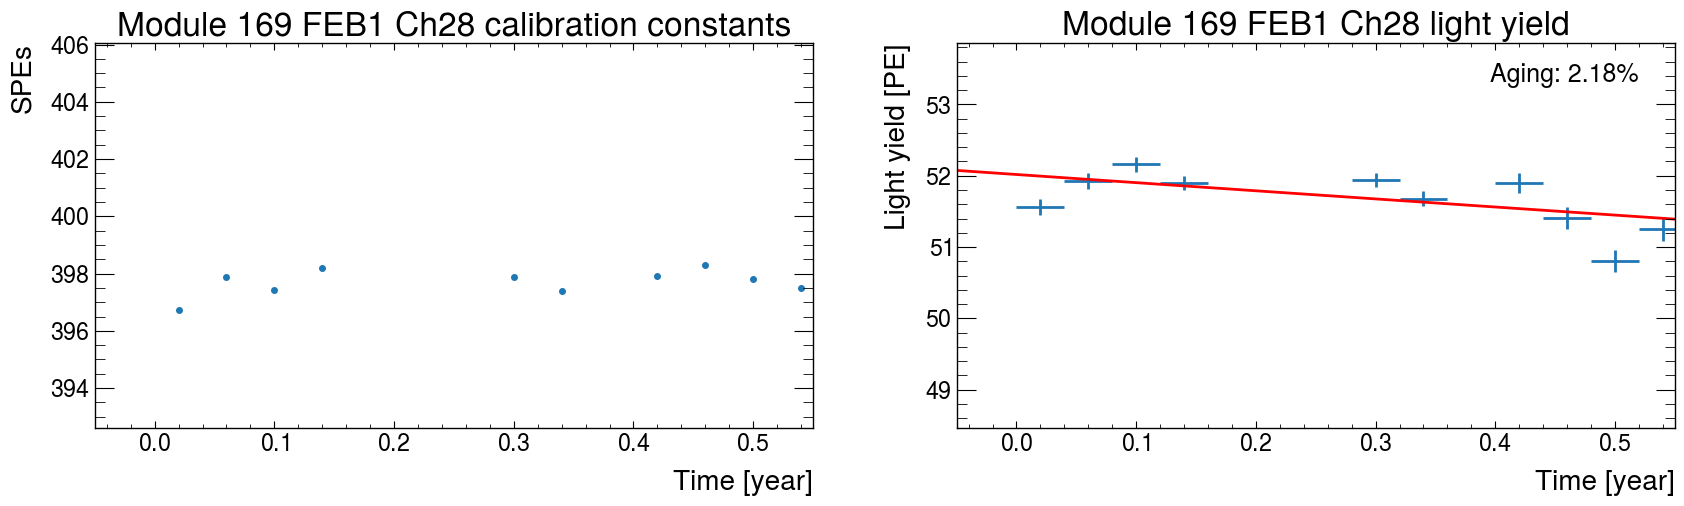

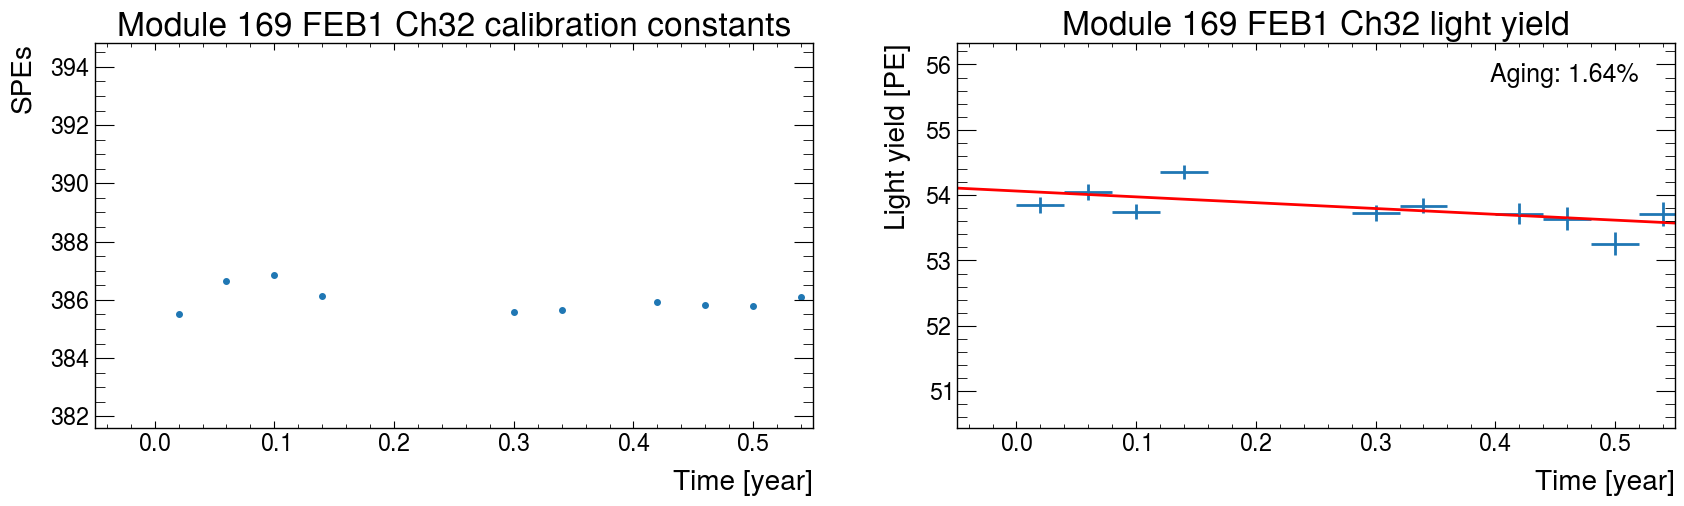

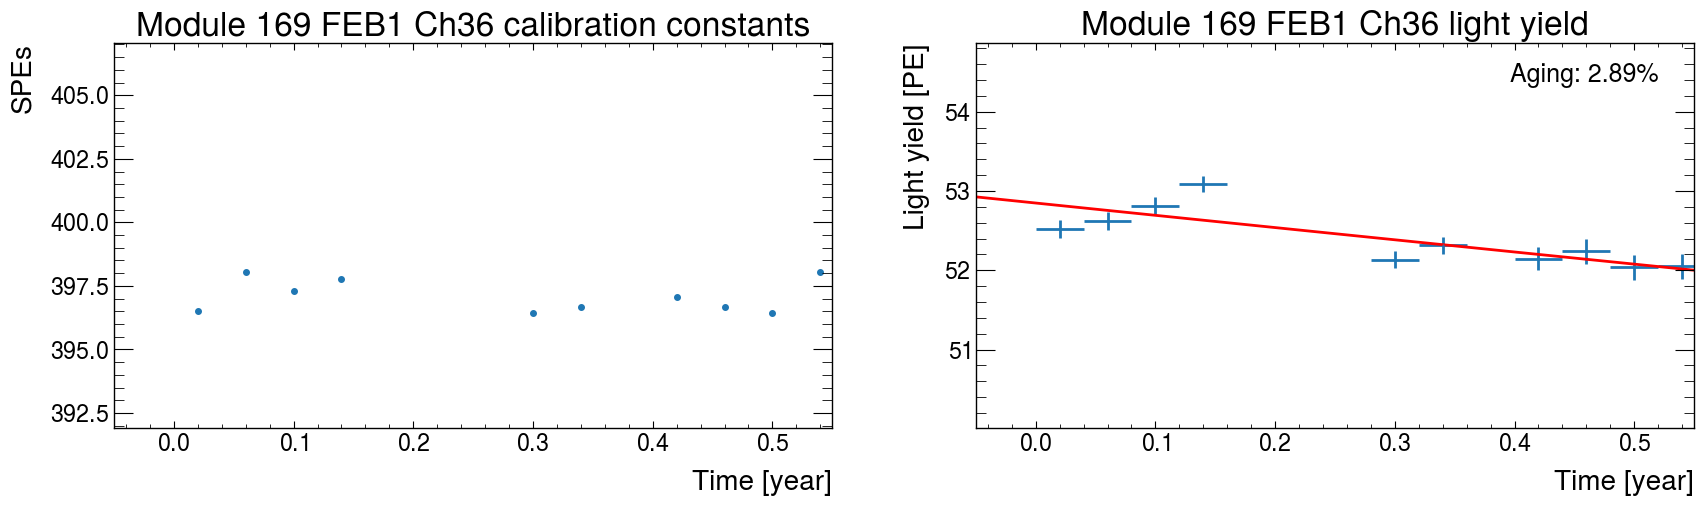

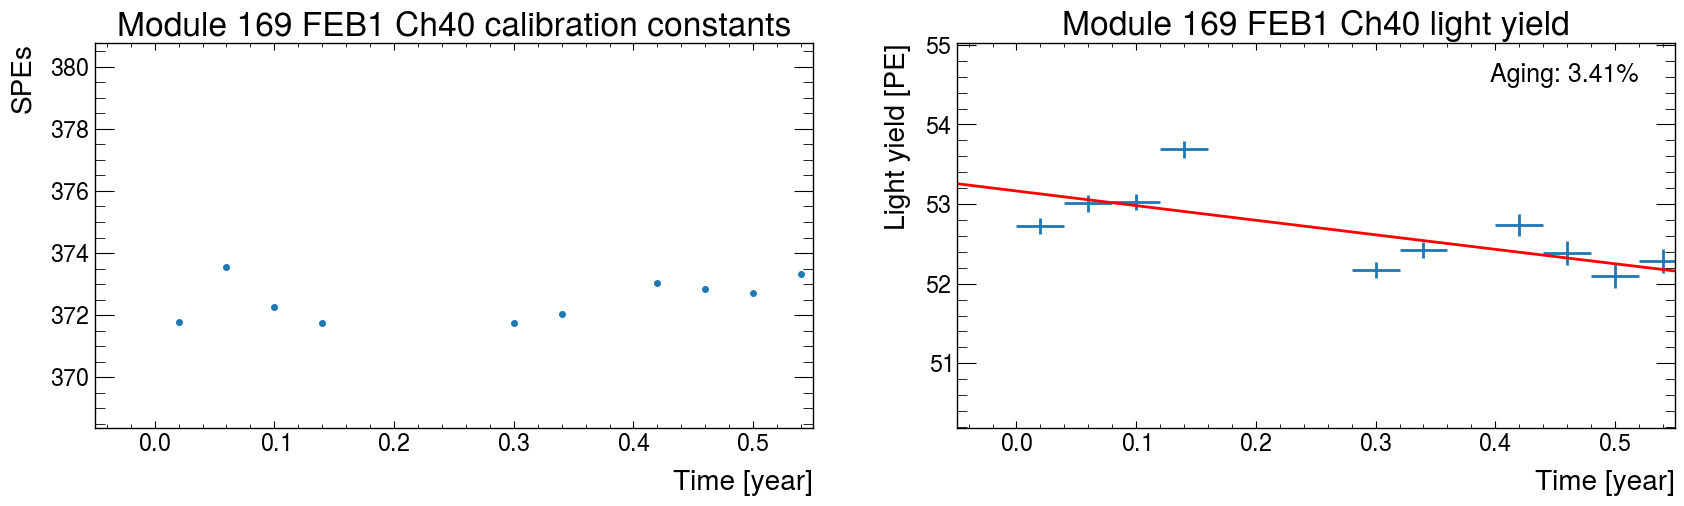

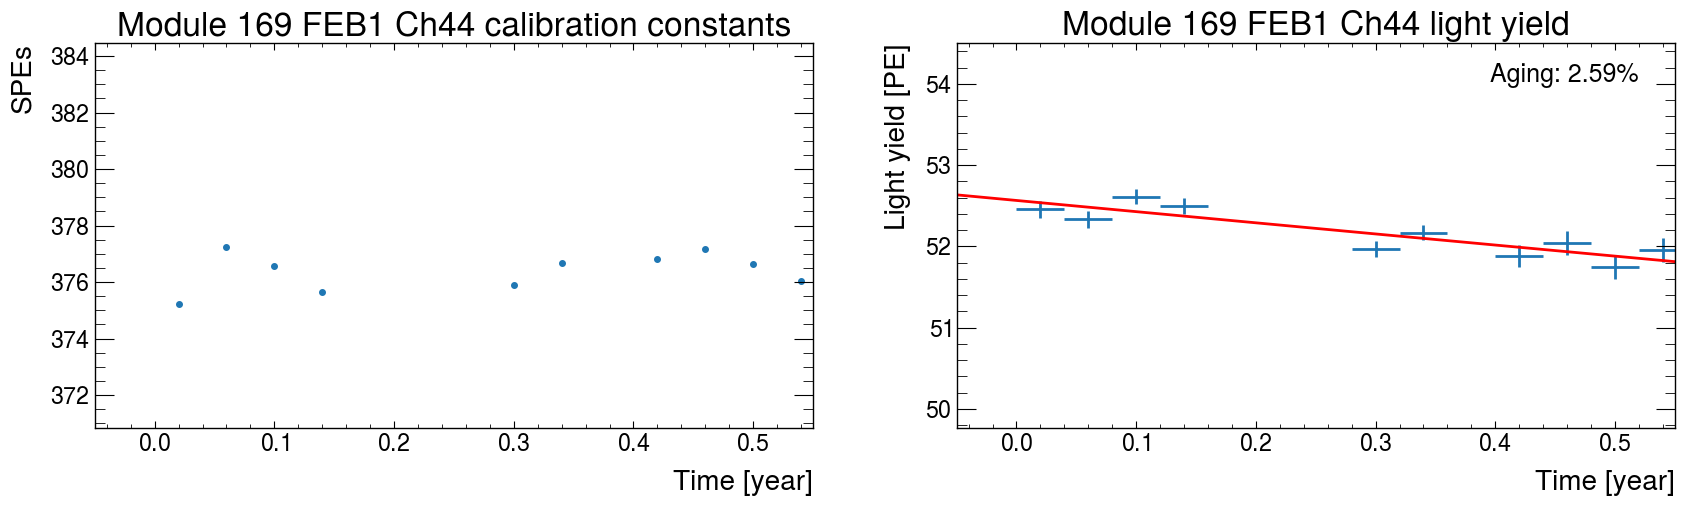

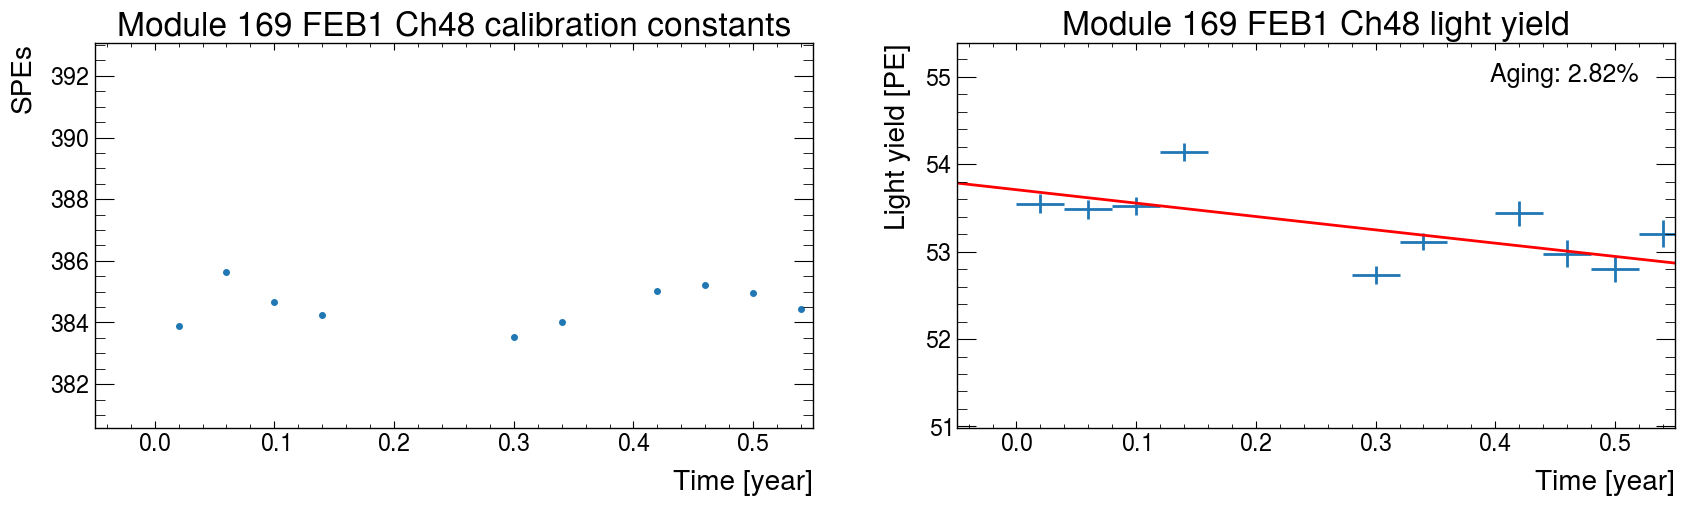

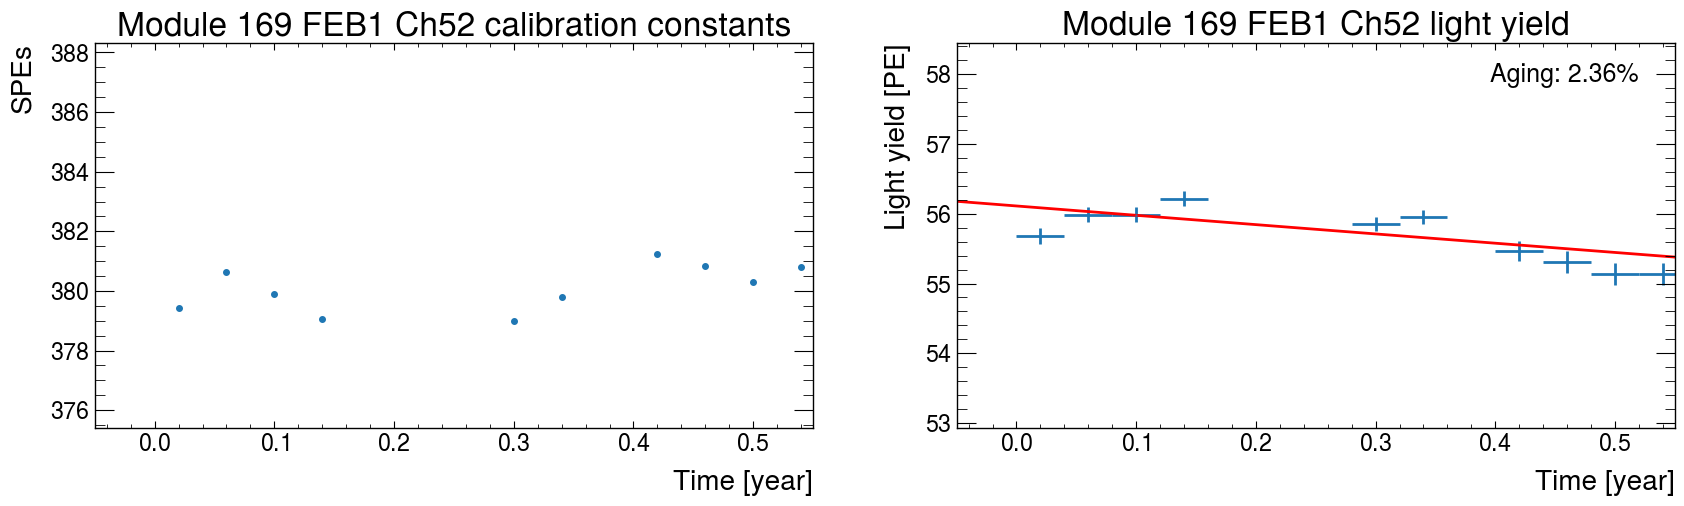

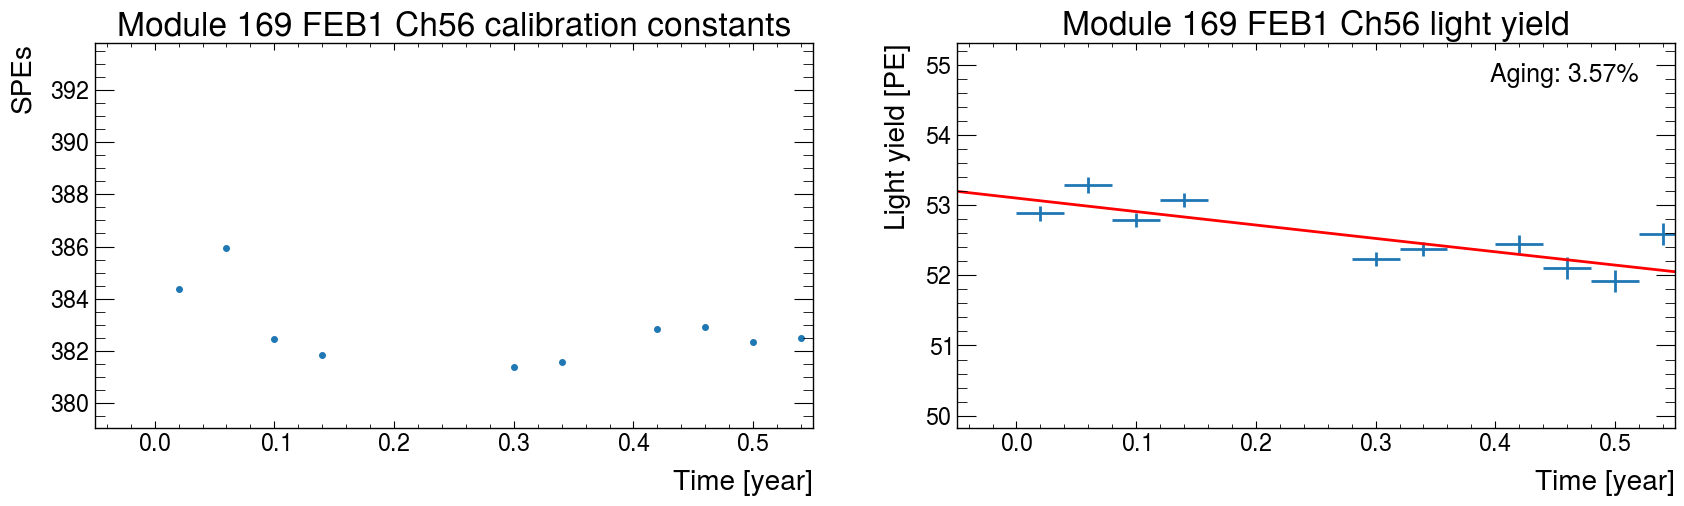

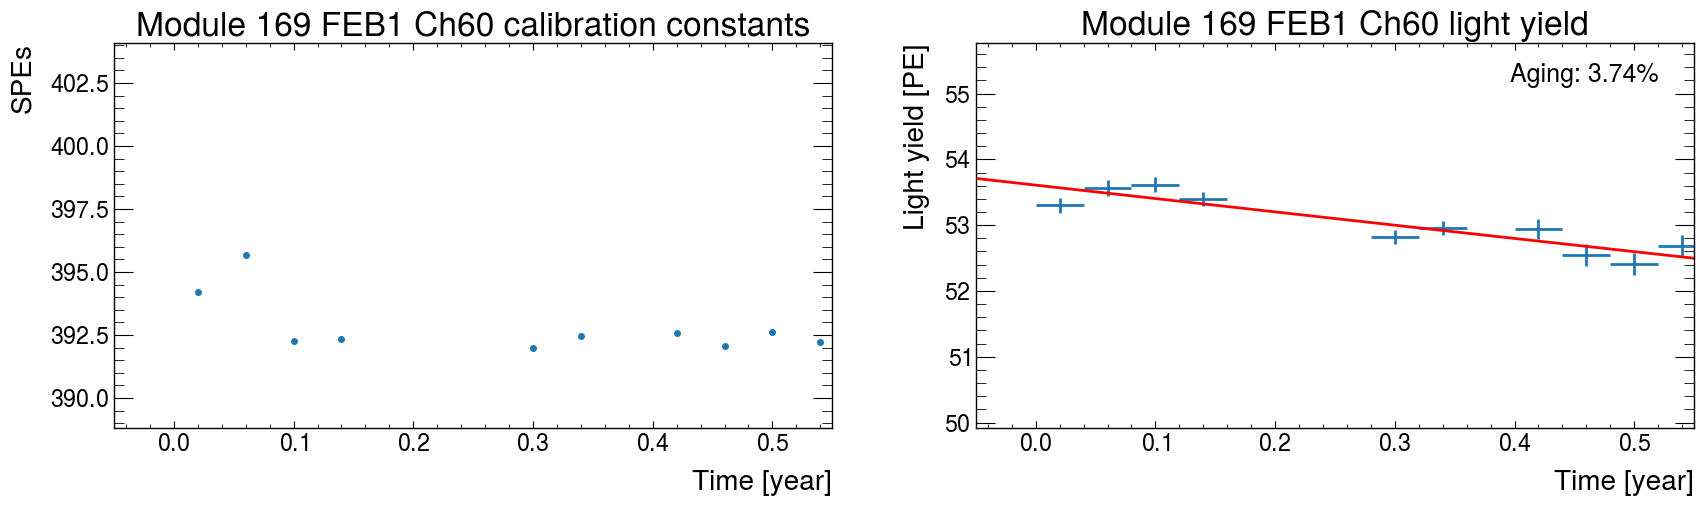

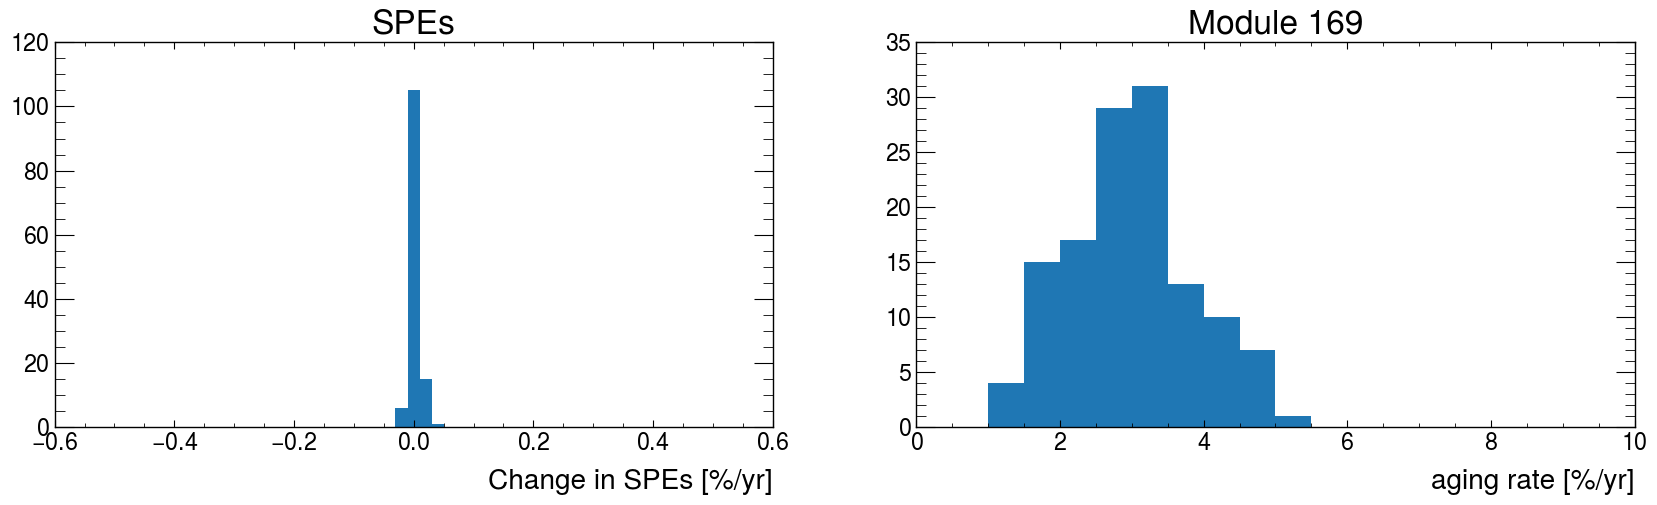

In [5]:
SPE_aging = []
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["SPEs_{0}".format(chan)],
                                          statistic='mean', bins=25, range=(0,1))
    d["SPEs_binned_{0}".format(chan)] = binned_stats[0]
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
    valid = ~(np.isnan(d["SPEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]))
    fit = np.polyfit(d["dt_binned_{0}".format(chan)][valid], d["SPEs_binned_{0}".format(chan)][valid], 1)
    SPE_aging.append(-1*fit[0]/d["SPEs_{0}".format(chan)][0])
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=25, range=(0,1))
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                          statistic='mean', bins=25, range=(0,1))
    d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]

    if popt[1] < 1:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        ax0.plot(d['dt_binned_{0}'.format(chan)], d["SPEs_binned_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.02, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1)
        ax1.plot(np.linspace(-0.1, 3, 100), aging(np.linspace(-0.1, 3, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')
        ax1.set_xlabel('Time [year]')

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 169 FEB{0} Ch{1} calibration constants'.format(int(FEB), int(channel)))
        ax1.set_title('Module 169 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 0.55))
        ax1.set_xlim((-0.05, 0.55))

        ax0.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax1.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax1.text(.95, .95, 'Aging: {0}%'.format(round(popt[1], 2)), fontsize=18, ha='right', va='top', transform=ax1.transAxes)
        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.show()

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.hist(SPE_aging, bins = np.linspace(-0.5, 0.5, 50))
ax1.hist(PE_aging, bins = np.linspace(-1, 10, 23))

ax0.set_title('SPEs')
ax1.set_title('Module 169')
ax0.set_xlabel('Change in SPEs [%/yr]')
ax1.set_xlabel('aging rate [%/yr]')

ax1.set_xlim((0,10))

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.show()

In [6]:
for chan in range(128):
    if chan in lowaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 0.75))
        ax1.set_xlim((-0.1, 0.75))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()

/tmp/ipykernel_14488/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x


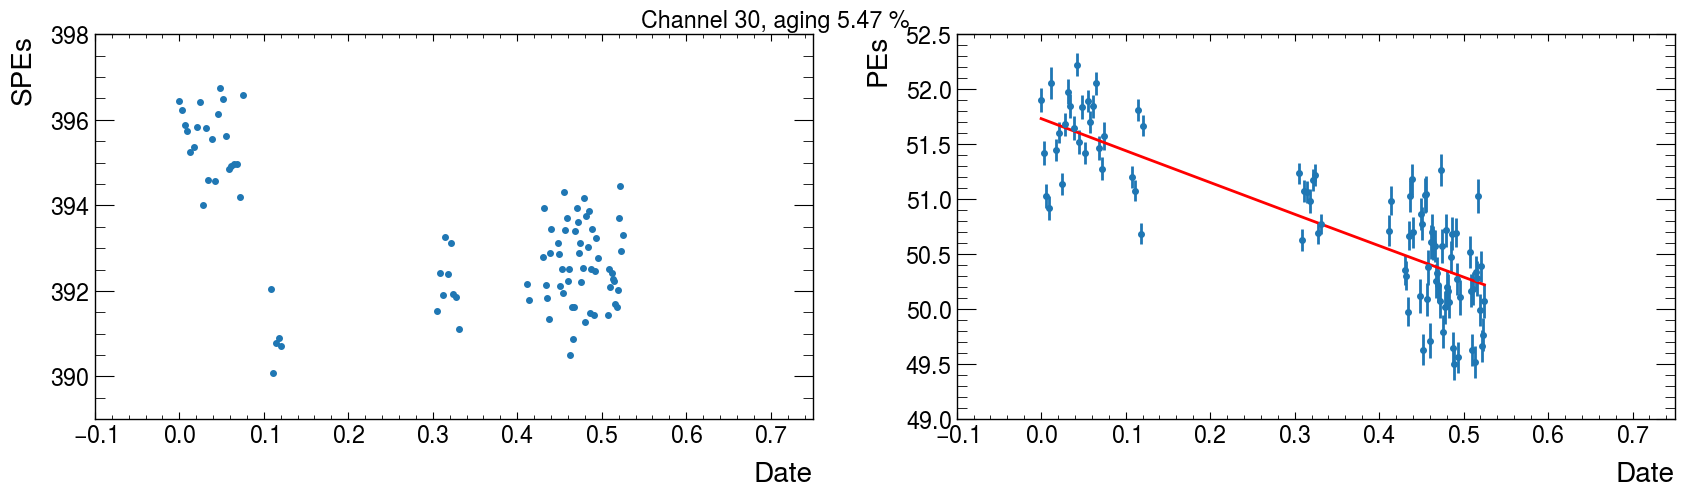

In [7]:
for chan in range(128):
    if chan in highaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 0.75))
        ax1.set_xlim((-0.1, 0.75))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()

In [8]:
runs = [1160, 1169, 1178, 2038, 1241, 1177, 1168, 1170, 1167, 1159, 1240]#,1218, 1209]
processor = wideband.DataProcessor(usexroot=True, treename='runSummary', runlist=runs, userunlist=True, remove=False)
filelist = processor.getFilelist(DATASET)
filelist = ["{}{}".format(i, ":runSummary") for i in filelist]

In [9]:
varlist = ['runNumber', 'subrunNumber', 'timestamp', 'PEsTemperatureCorrected',
           'calibConstantsTemperatureCorrected', 'FWHMsTemperatureCorrected', 'signalsTemperatureCorrected']
d = {}
for chan in range(128):
    d["SPEs_{0}".format(chan)] = []
    d["PEs_{0}".format(chan)] = []
    d["PEs_sigma_{0}".format(chan)] = []
    d["time_{0}".format(chan)] = []
badchannels = []
    
for idx, filename in enumerate(filelist):
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="10MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['SPEsTemperatureCorrected'] = ak.mask(ar['calibConstantsTemperatureCorrected'], ar['calibConstantsTemperatureCorrected']>0)
            for chan in range(64):
                if ar['timestamp'][0] > 0:
                    if ar['PEsTemperatureCorrected'][0,2,chan] > 0:
                        d["SPEs_{0}".format(chan+64)].append(ar['SPEsTemperatureCorrected'][0,2,chan])
                        d["PEs_{0}".format(chan+64)].append(ar['PEsTemperatureCorrected'][0,2,chan])
                        d["PEs_sigma_{0}".format(chan+64)].append(ar['FWHMsTemperatureCorrected'][0,2,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,2,chan])))
                        d["time_{0}".format(chan+64)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan+64)
                    if ar['PEsTemperatureCorrected'][0,1,chan] > 0:
                        d["SPEs_{0}".format(chan)].append(ar['SPEsTemperatureCorrected'][0,1,chan])
                        d["PEs_{0}".format(chan)].append(ar['PEsTemperatureCorrected'][0,1,chan])
                        d["PEs_sigma_{0}".format(chan)].append(ar['FWHMsTemperatureCorrected'][0,1,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,1,chan])))
                        d["time_{0}".format(chan)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan)

for chan in range(128):
    if chan in badchannels:
        continue
    else:
        d["time_{0}".format(chan)] = np.array(d["time_{0}".format(chan)])
        d["dt_{0}".format(chan)] = (d["time_{0}".format(chan)] - d["time_{0}".format(chan)][0])/(60*60*24*365.25)
        d["SPEs_{0}".format(chan)] = np.array(d["SPEs_{0}".format(chan)])
        d["PEs_{0}".format(chan)] = np.array(d["PEs_{0}".format(chan)])
        d["PEs_sigma_{0}".format(chan)] = np.array(d["PEs_sigma_{0}".format(chan)])

/tmp/ipykernel_14488/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x
/tmp/ipykernel_14488/2543687658.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1) = plt.subplots(1, 2)


low aging 110


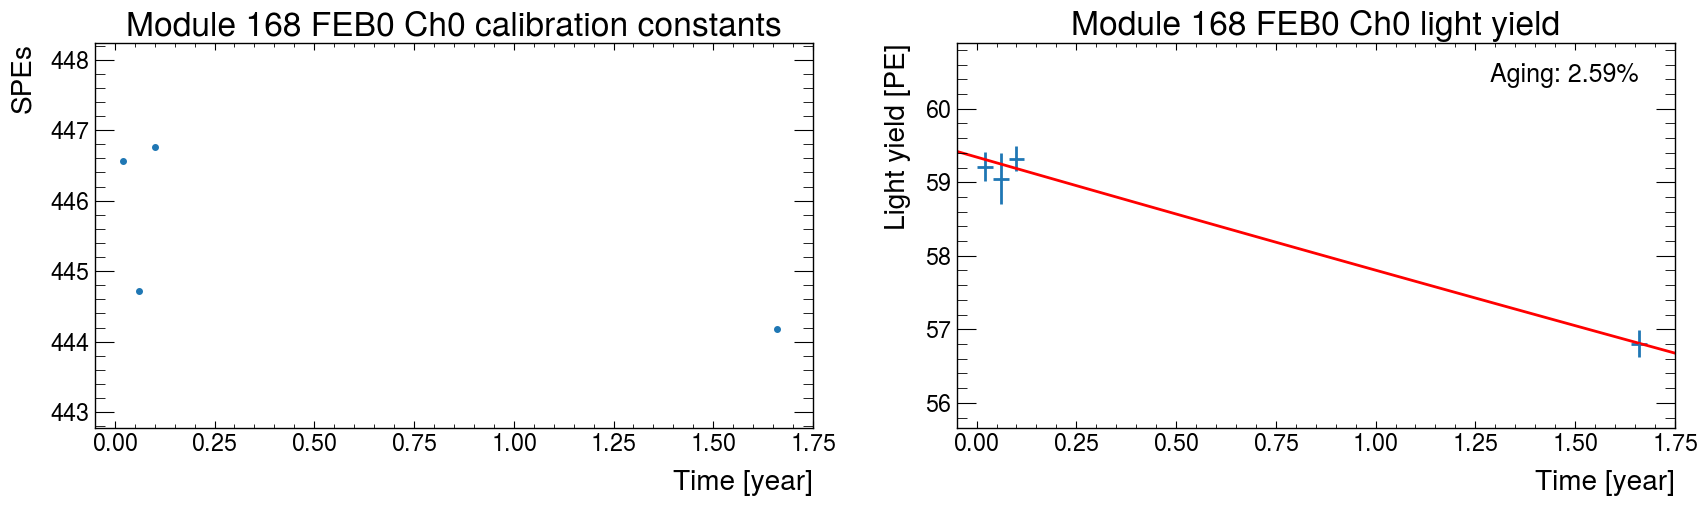

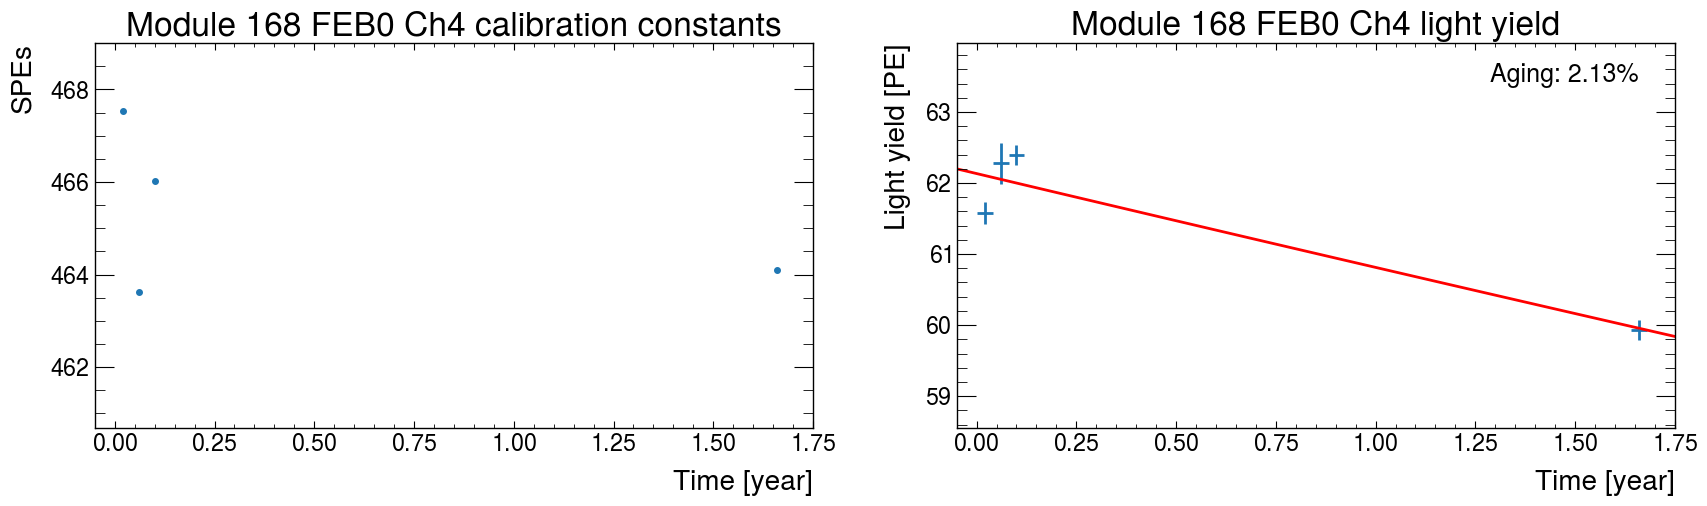

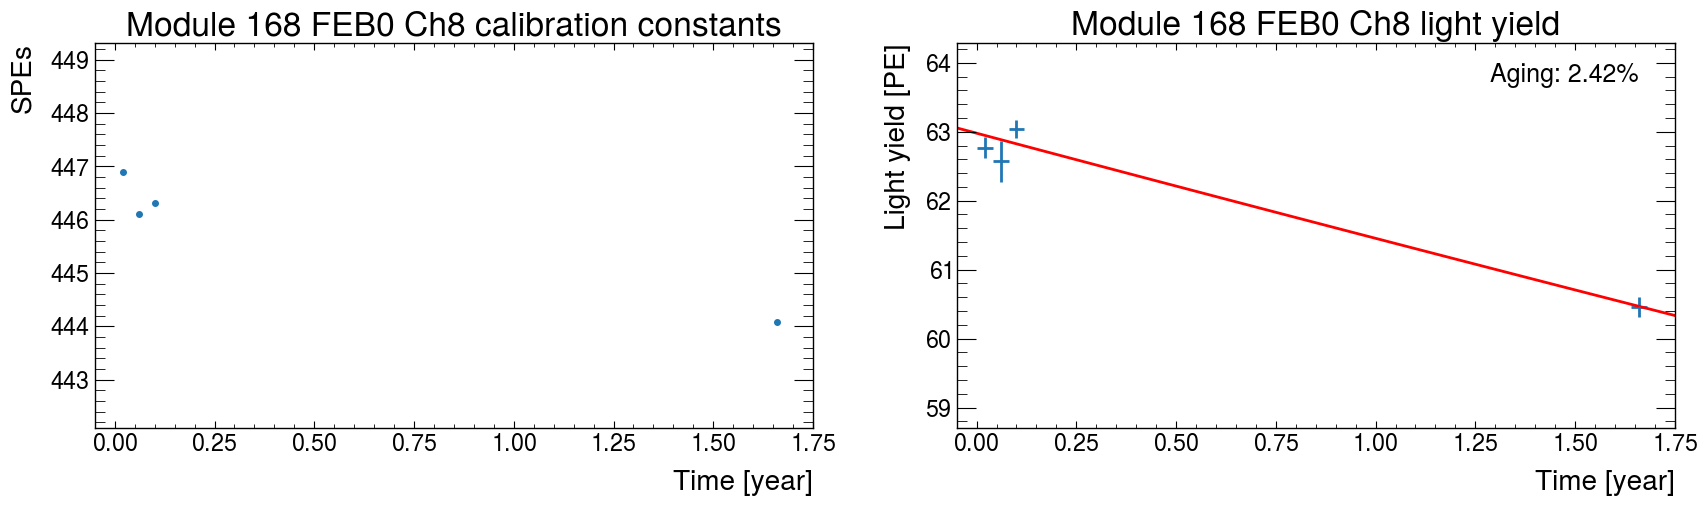

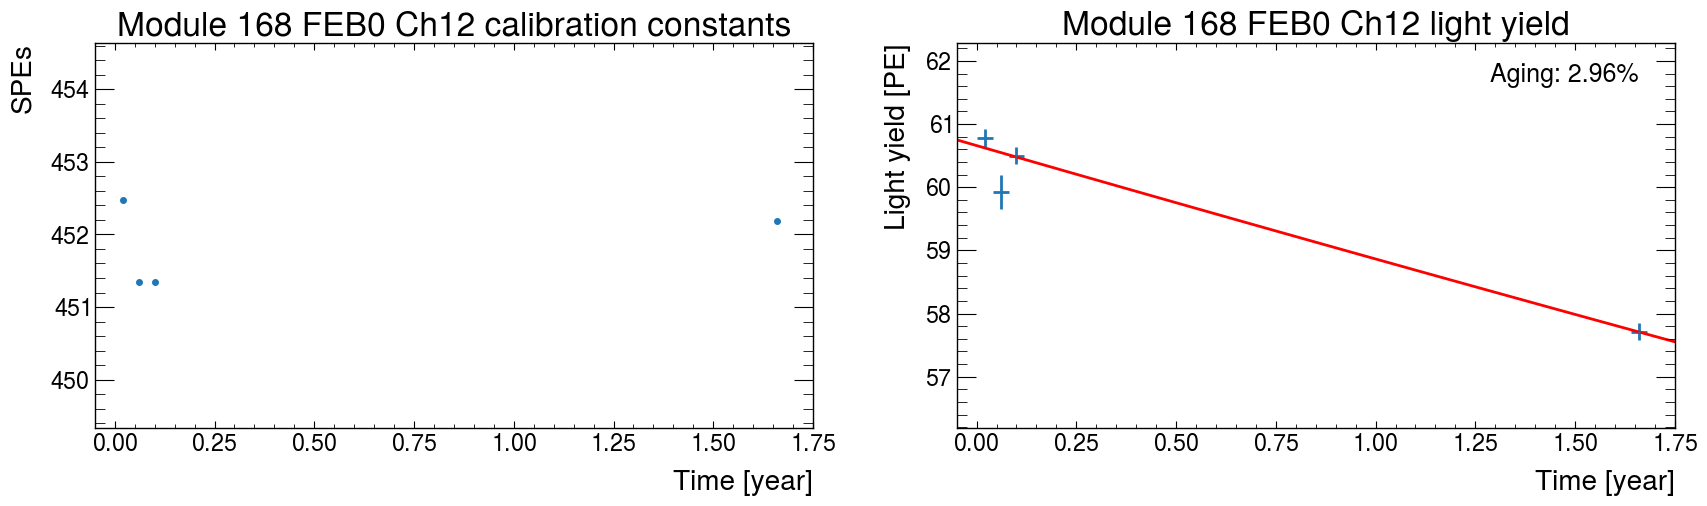

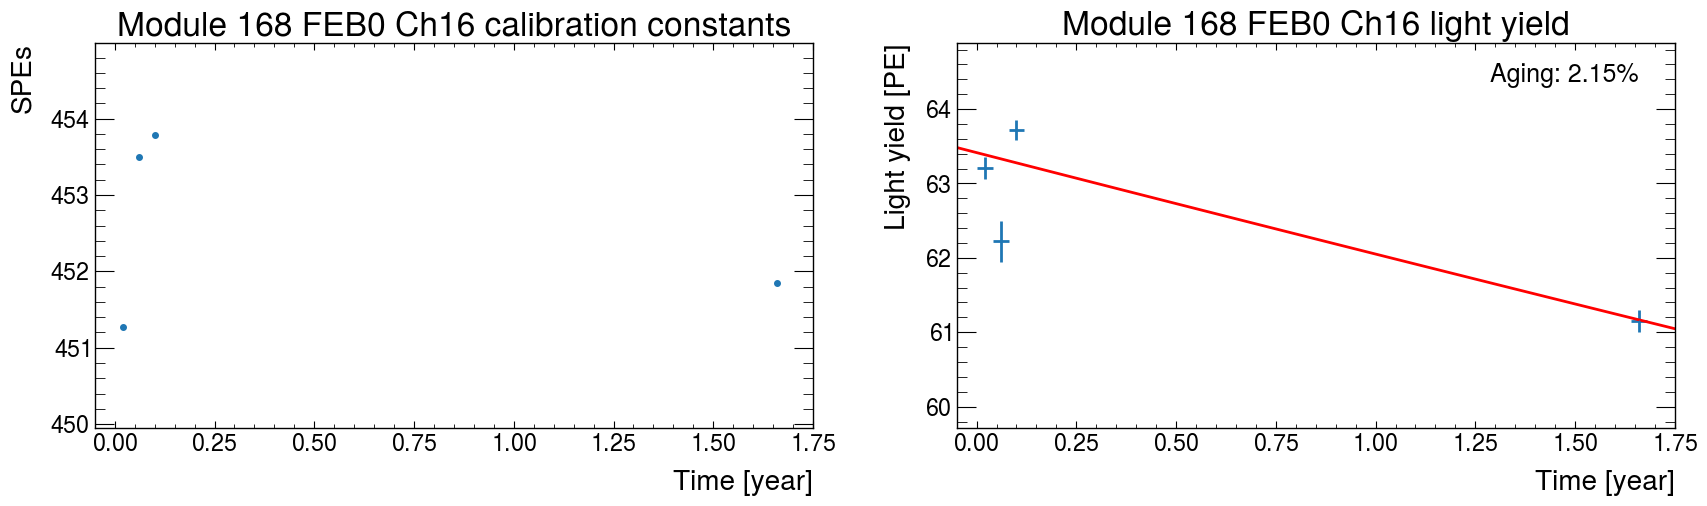

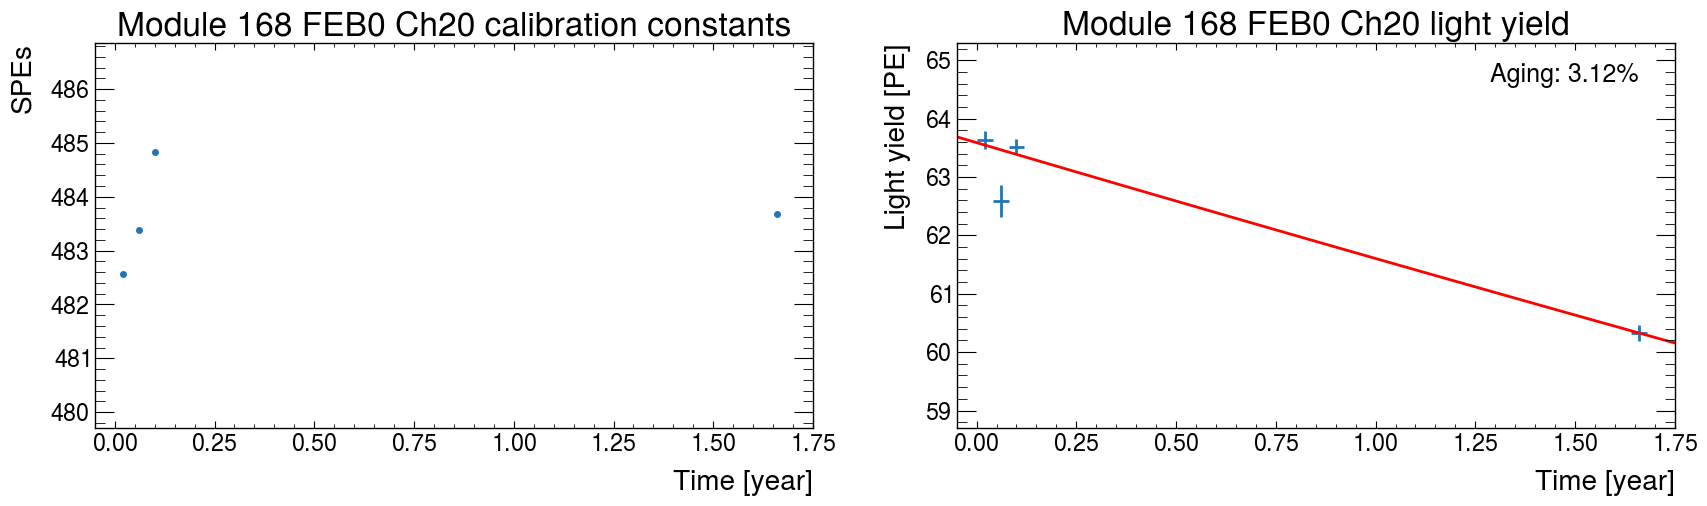

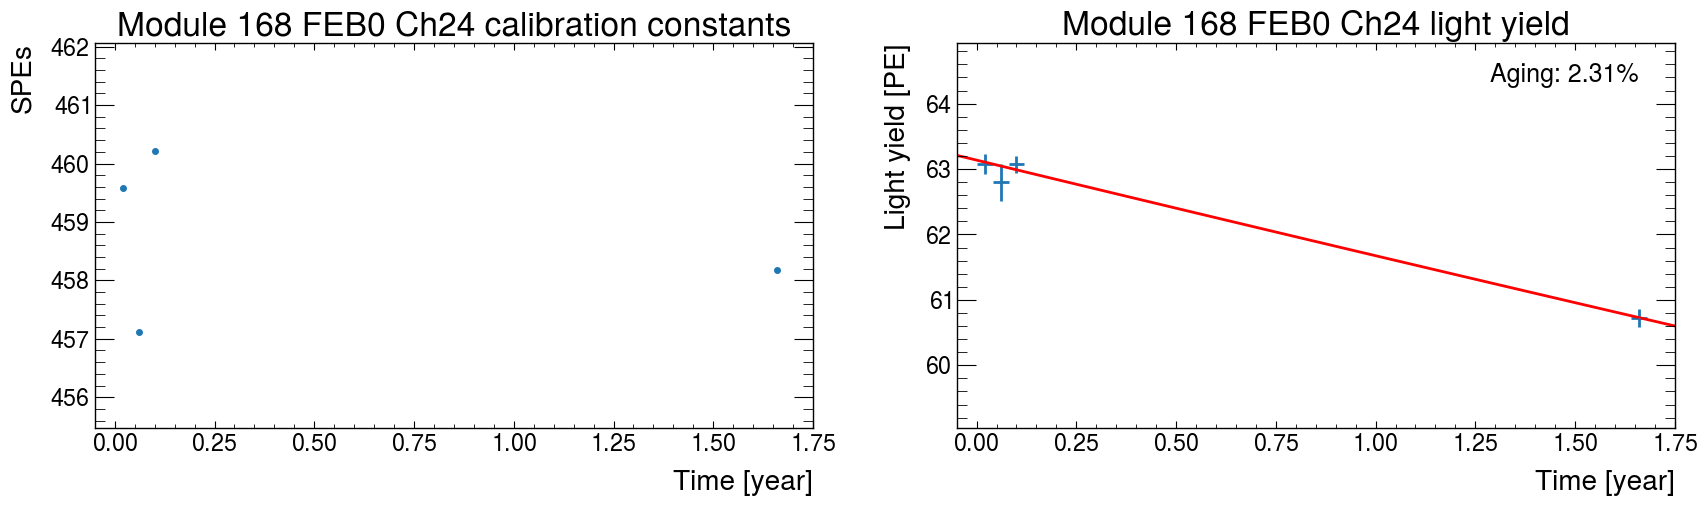

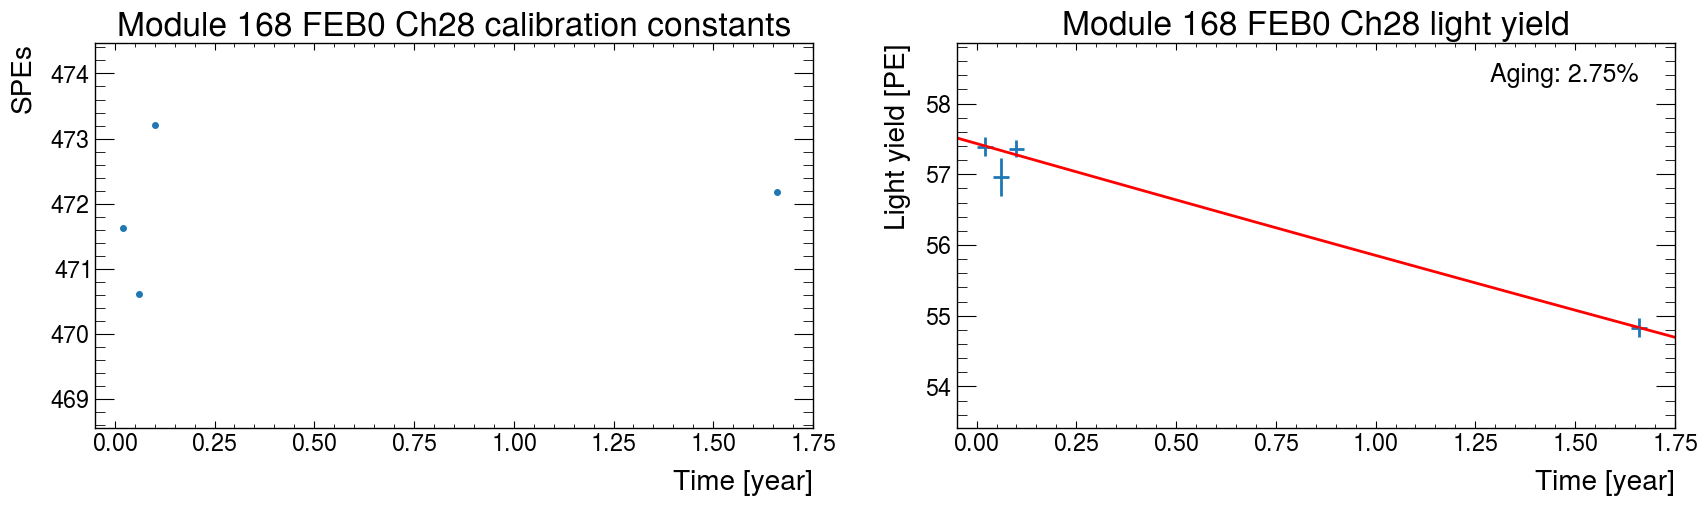

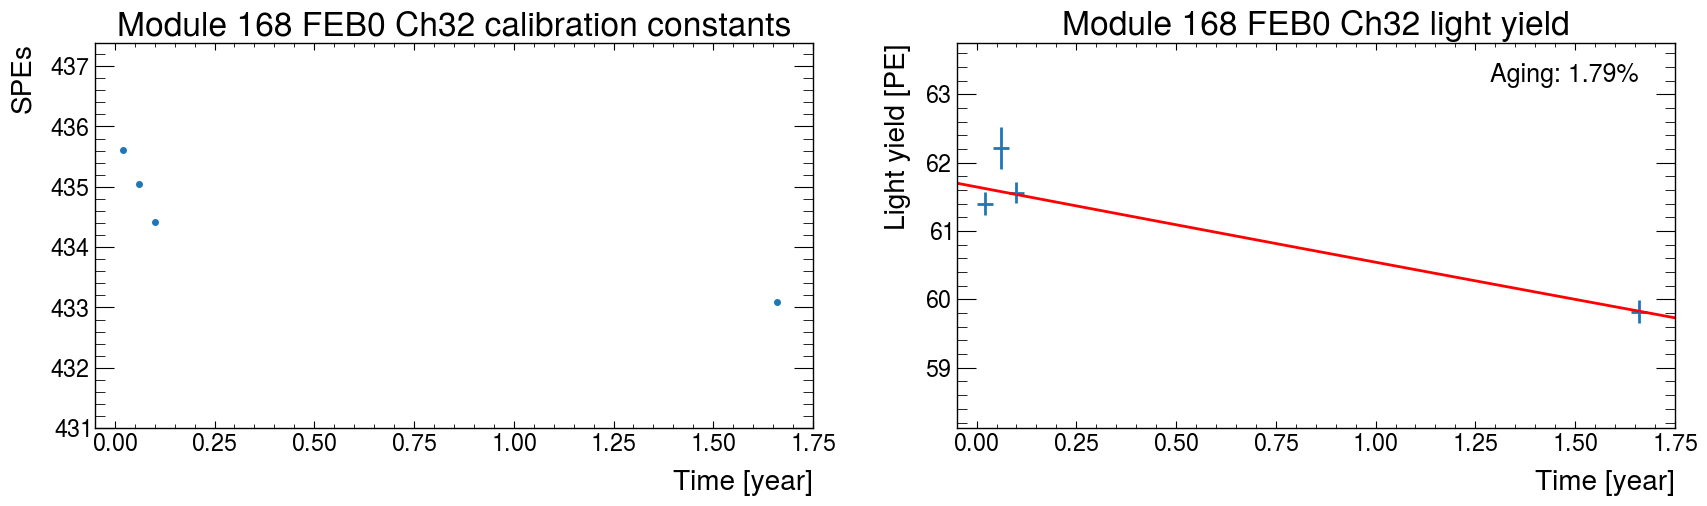

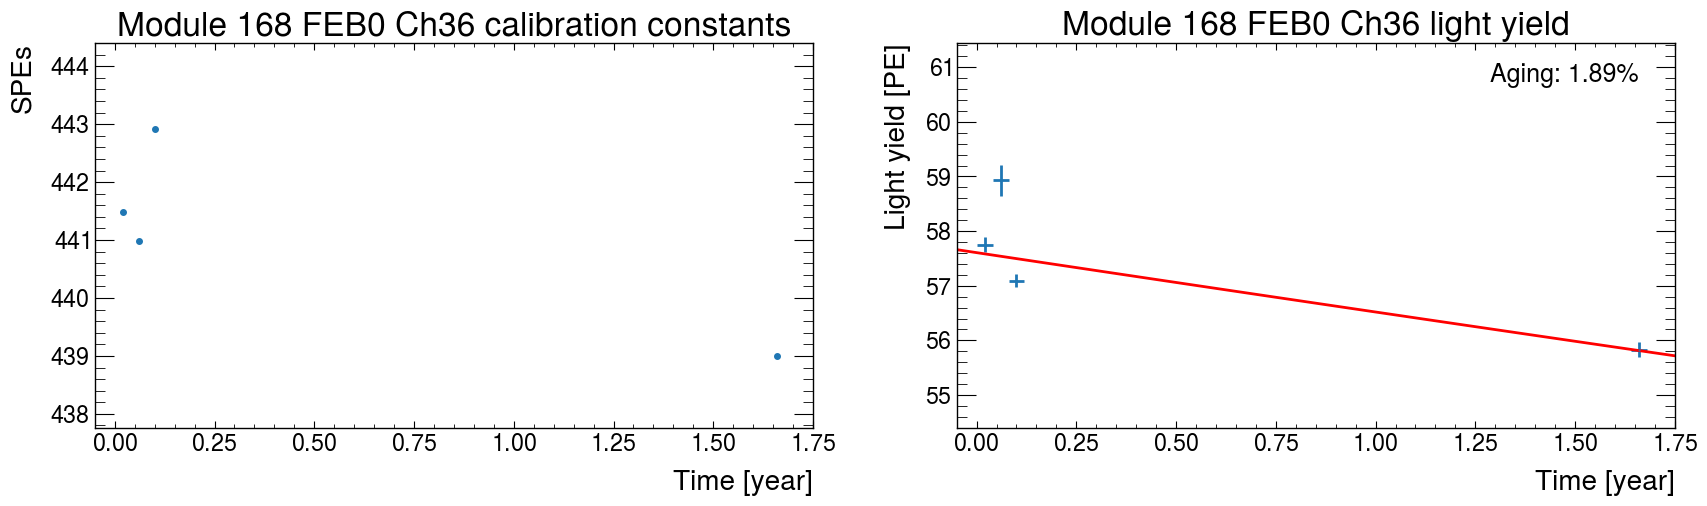

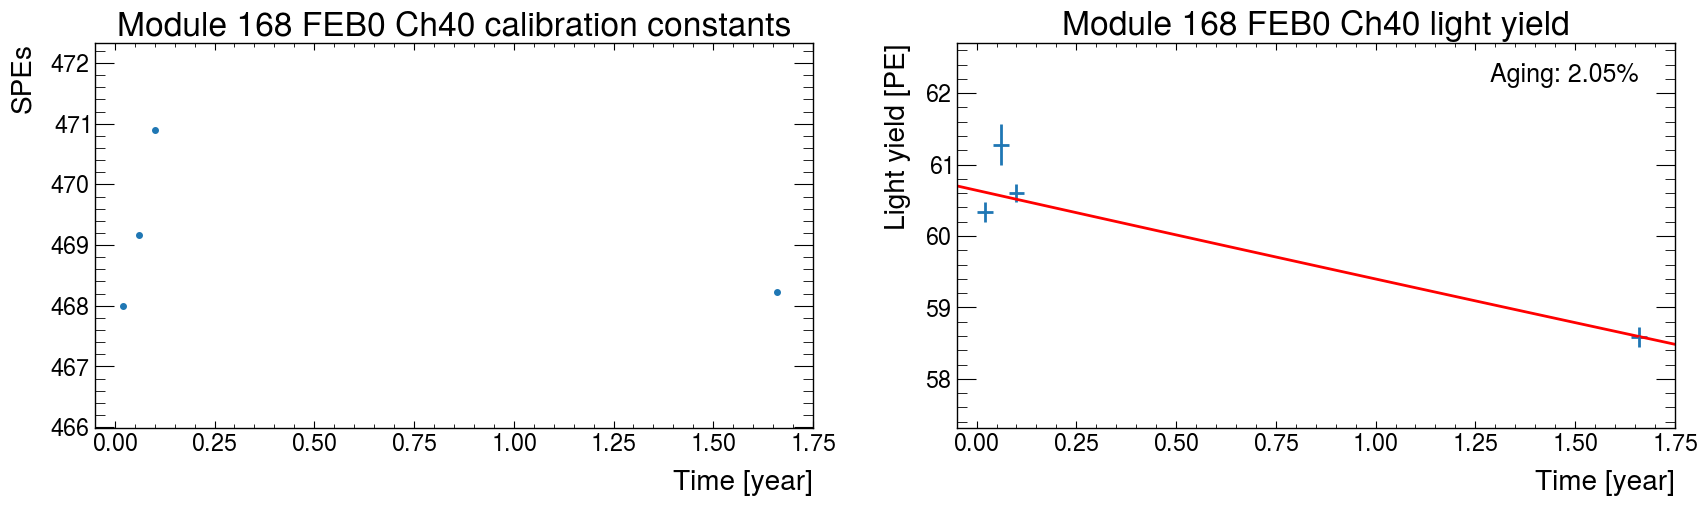

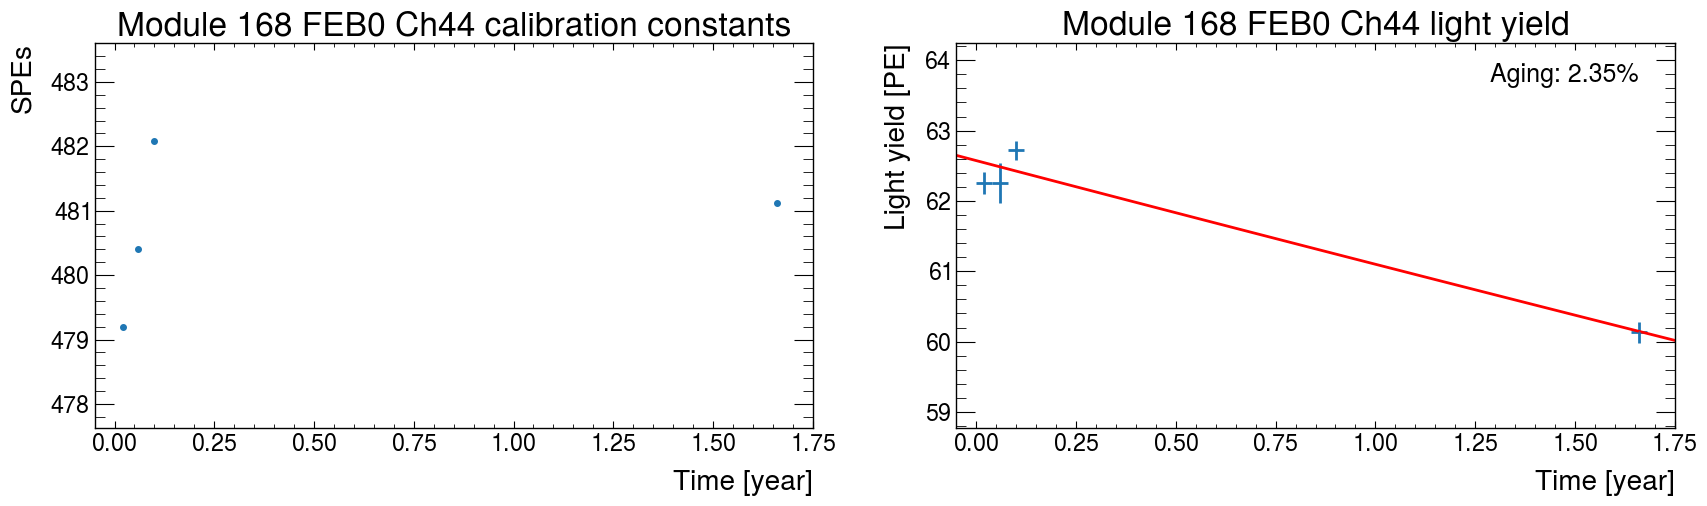

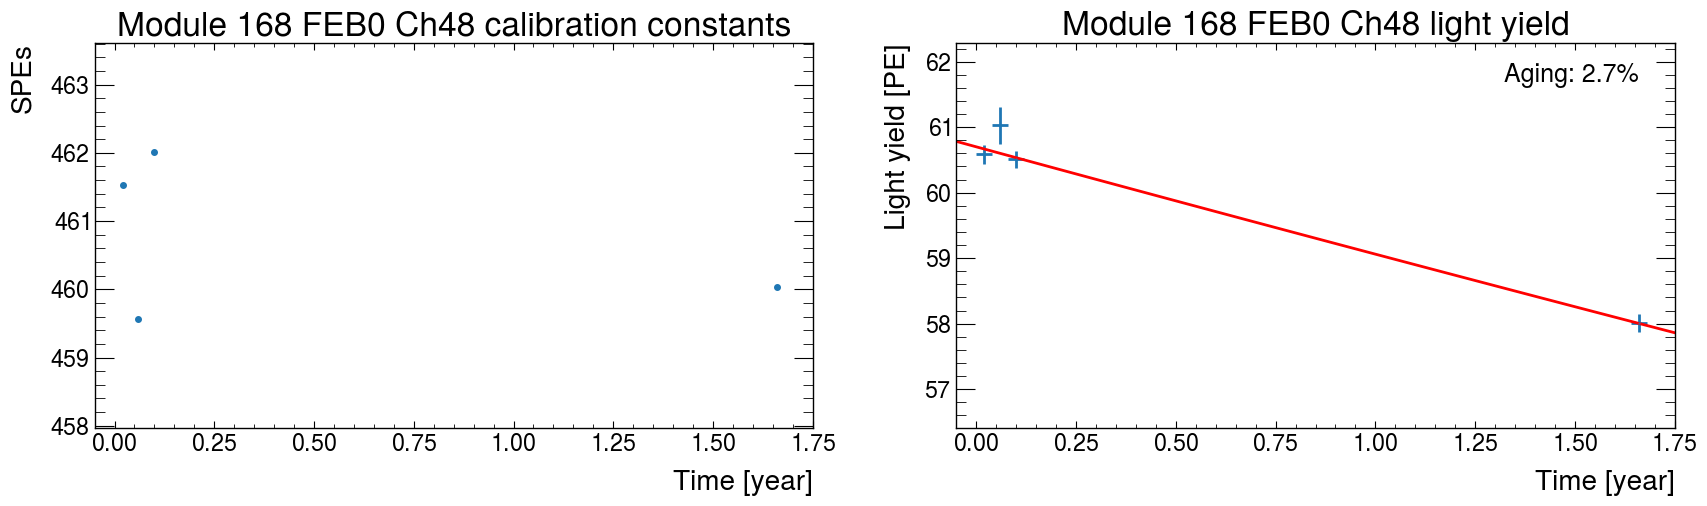

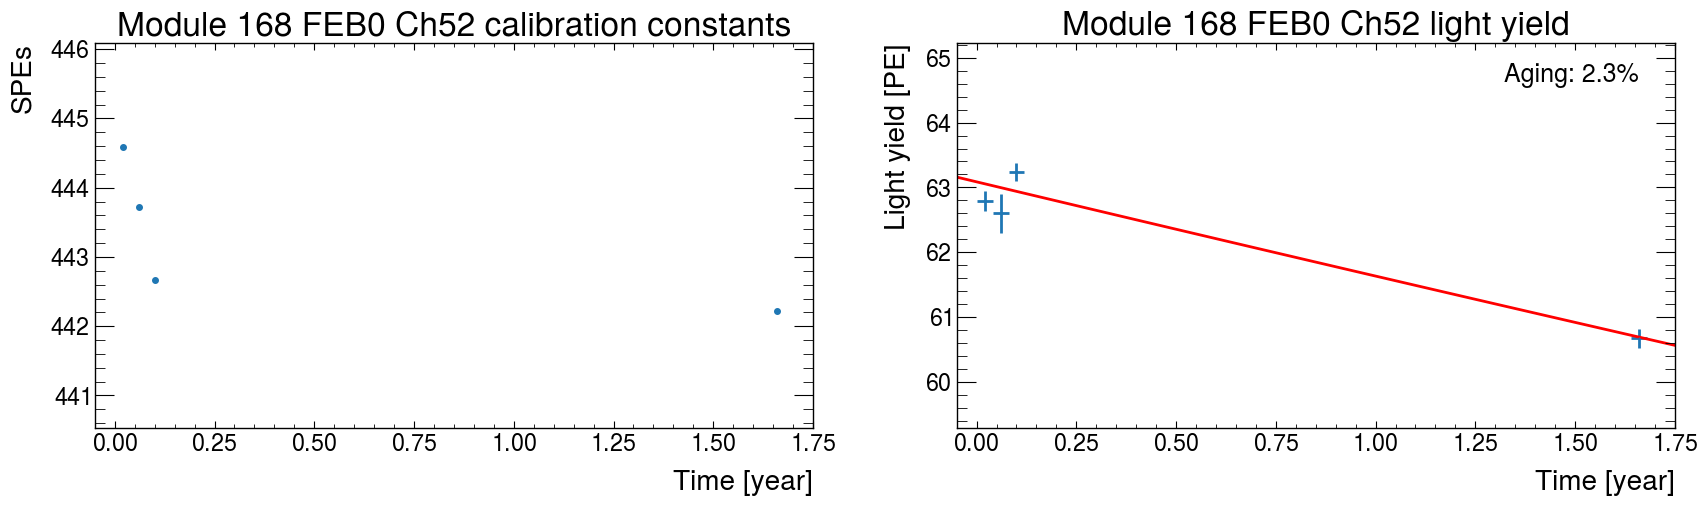

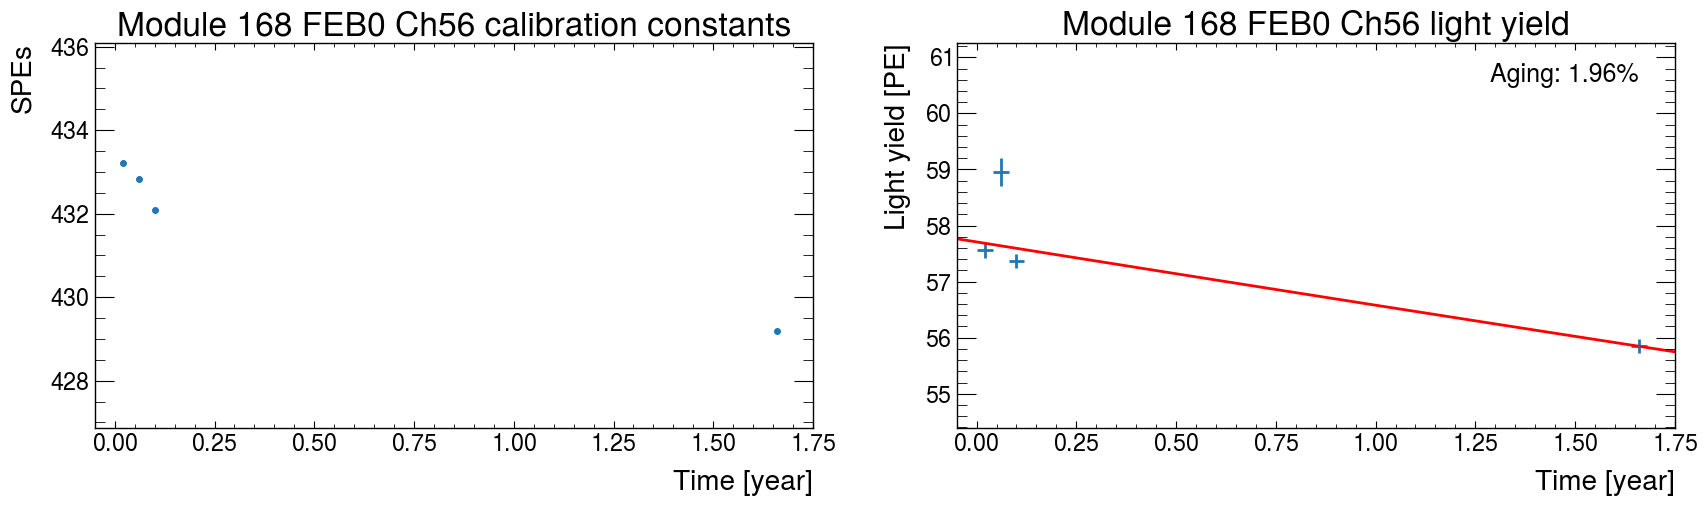

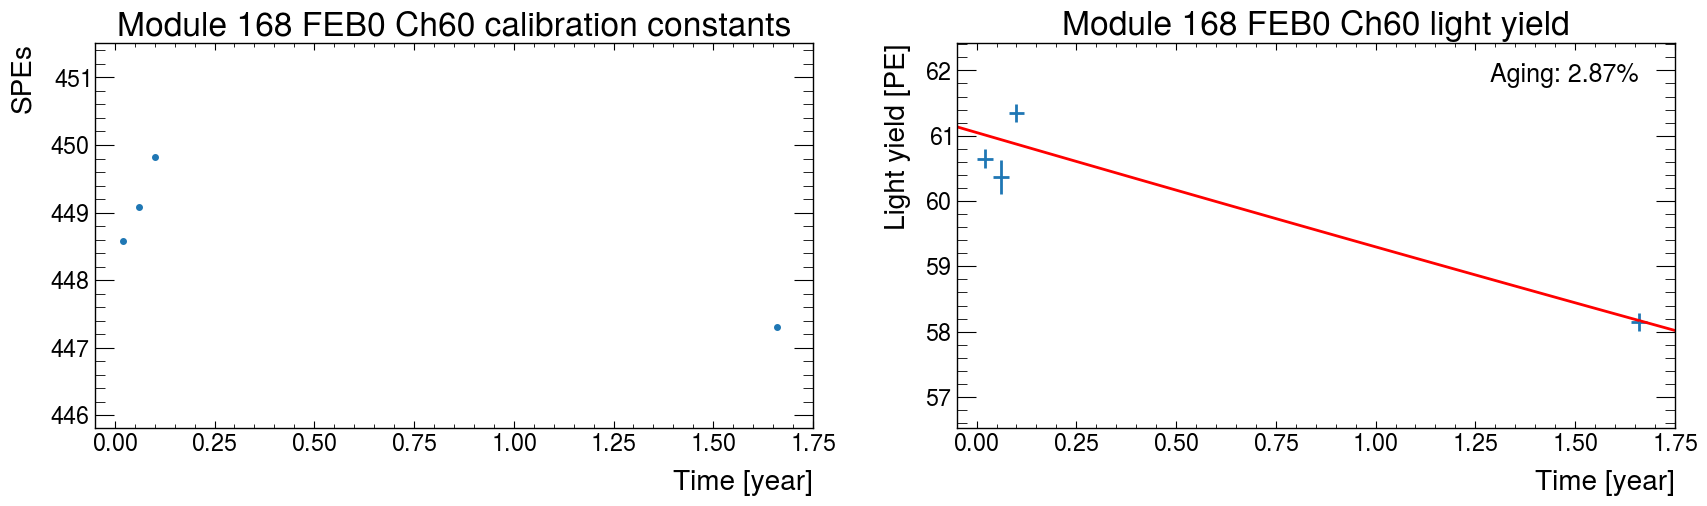

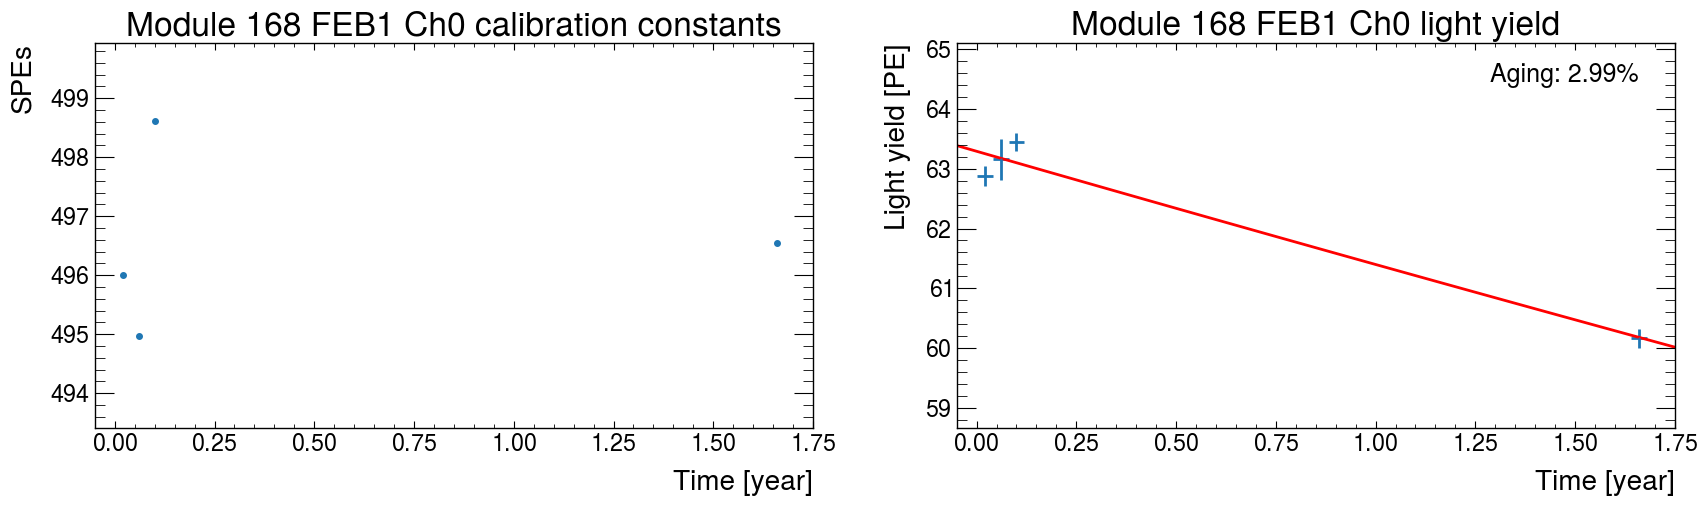

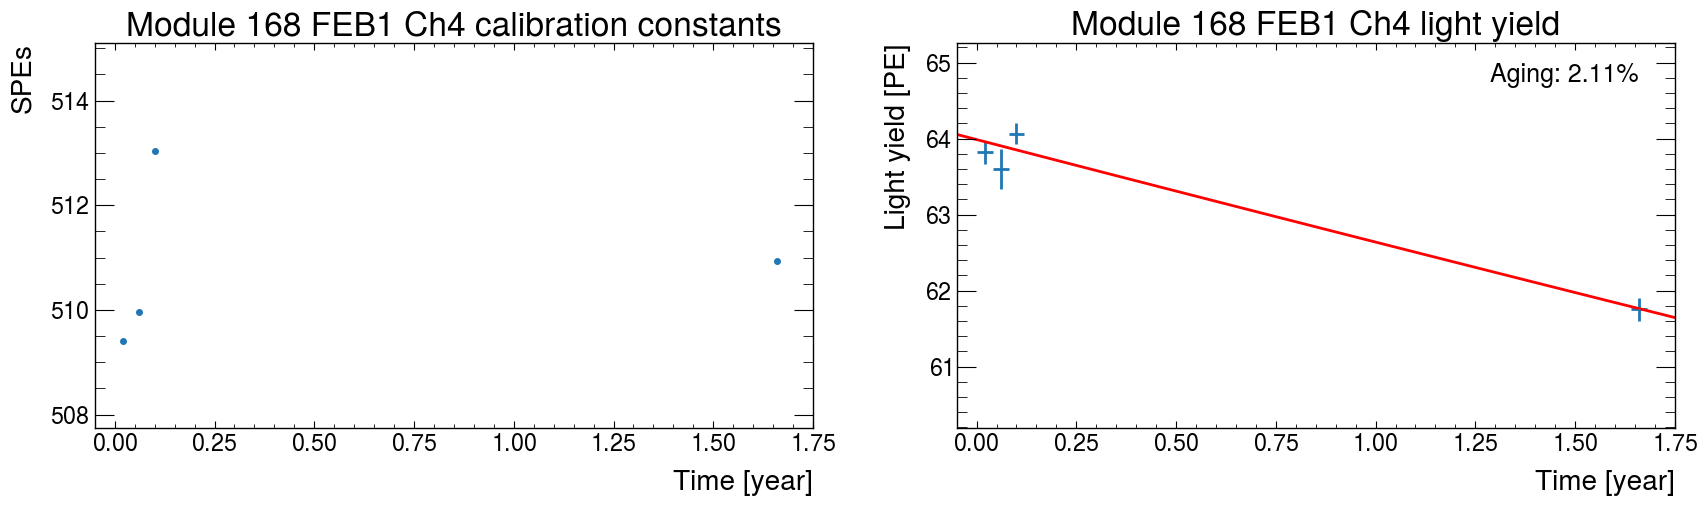

In [ ]:
SPE_aging = []
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["SPEs_{0}".format(chan)],
                                          statistic='mean', bins=50, range=(0,2))
    d["SPEs_binned_{0}".format(chan)] = binned_stats[0]
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
    valid = ~(np.isnan(d["SPEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]))
    fit = np.polyfit(d["dt_binned_{0}".format(chan)][valid], d["SPEs_binned_{0}".format(chan)][valid], 1)
    SPE_aging.append(-1*fit[0]/d["SPEs_{0}".format(chan)][0])
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=50, range=(0,2))
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                          statistic='mean', bins=50, range=(0,2))
    d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]

    if popt[1] < 1:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        ax0.plot(d['dt_binned_{0}'.format(chan)], d["SPEs_binned_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.02, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1)
        ax1.plot(np.linspace(-0.1, 3, 100), aging(np.linspace(-0.1, 3, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')
        ax1.set_xlabel('Time [year]')

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 168 FEB{0} Ch{1} calibration constants'.format(int(FEB), int(channel)))
        ax1.set_title('Module 168 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 1.75))
        ax1.set_xlim((-0.05, 1.75))

        ax0.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax1.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))
        
        ax1.text(.95, .95, 'Aging: {0}%'.format(round(popt[1], 2)), fontsize=18, ha='right', va='top', transform=ax1.transAxes)

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.show()

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.hist(SPE_aging, bins = np.linspace(-0.5, 0.5, 50))
ax1.hist(PE_aging, bins = np.linspace(-1, 10, 23))

ax0.set_title('SPEs')
ax1.set_title('Module 168')
ax0.set_xlabel('Change in SPEs [%/yr]')
ax1.set_xlabel('aging rate [%/yr]')

ax1.set_xlim((0,10))

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.show()

In [ ]:
for chan in range(128):
    if chan in lowaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 2))
        ax1.set_xlim((-0.1, 2))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()

In [ ]:
for chan in range(128):
    if chan in highaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 2))
        ax1.set_xlim((-0.1, 2))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()

In [ ]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"

runs = [66, 94, 105, 119, 1010, 1020, 1021, 1022, 1031, 1033, 1034, 1035,
        1243, 1244, 1245, 1246, 1247, 1248, 1251, 1262, 1264, 1276, 1279, 1280, 1281, 1284, 1285, 1286, 1287, 1288,
        1312, 1315, 1327, 1341, 1354, 1370, 2044]
processor = wideband.DataProcessor(usexroot=True, treename='runSummary', runlist=runs, userunlist=True, remove=False,fixtimes=True)
filelist = processor.getFilelist(DATASET)
filelist = ["{}{}".format(i, ":runSummary") for i in filelist]

In [ ]:
varlist = ['runNumber', 'subrunNumber', 'timestamp', 'PEsTemperatureCorrected',
           'calibConstantsTemperatureCorrected', 'FWHMsTemperatureCorrected', 'signalsTemperatureCorrected']
d = {}
for chan in range(128):
    d["SPEs_{0}".format(chan)] = []
    d["PEs_{0}".format(chan)] = []
    d["PEs_sigma_{0}".format(chan)] = []
    d["time_{0}".format(chan)] = []
badchannels = []
    
for idx, filename in enumerate(filelist):
    with uproot.open(filename) as file:
        for ar in file.iterate(step_size="10MB", 
                               filter_name=varlist, 
                               report=False, library='ak'):
            ar['SPEsTemperatureCorrected'] = ak.mask(ar['calibConstantsTemperatureCorrected'], ar['calibConstantsTemperatureCorrected']>0)
            for chan in range(64):
                if ar['timestamp'][0] > 0:
                    if ar['PEsTemperatureCorrected'][0,0,chan] > 0:
                        d["SPEs_{0}".format(chan+64)].append(ar['SPEsTemperatureCorrected'][0,0,chan])
                        d["PEs_{0}".format(chan+64)].append(ar['PEsTemperatureCorrected'][0,0,chan])
                        d["PEs_sigma_{0}".format(chan+64)].append(ar['FWHMsTemperatureCorrected'][0,0,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,0,chan])))
                        d["time_{0}".format(chan+64)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan+64)
                    if ar['PEsTemperatureCorrected'][0,1,chan] > 0:
                        d["SPEs_{0}".format(chan)].append(ar['SPEsTemperatureCorrected'][0,1,chan])
                        d["PEs_{0}".format(chan)].append(ar['PEsTemperatureCorrected'][0,1,chan])
                        d["PEs_sigma_{0}".format(chan)].append(ar['FWHMsTemperatureCorrected'][0,1,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,1,chan])))
                        d["time_{0}".format(chan)].append(ar['timestamp'][0])
                    else:
                        badchannels.append(chan)

for chan in range(128):
    if chan in badchannels:
        continue
    else:
        d["time_{0}".format(chan)] = np.array(d["time_{0}".format(chan)])
        d["dt_{0}".format(chan)] = (d["time_{0}".format(chan)] - d["time_{0}".format(chan)][0])/(60*60*24*365.25)
        d["SPEs_{0}".format(chan)] = np.array(d["SPEs_{0}".format(chan)])
        d["PEs_{0}".format(chan)] = np.array(d["PEs_{0}".format(chan)])
        d["PEs_sigma_{0}".format(chan)] = np.array(d["PEs_sigma_{0}".format(chan)])

In [ ]:
SPE_aging = []
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["SPEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["SPEs_binned_{0}".format(chan)] = binned_stats[0]
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
    valid = ~(np.isnan(d["SPEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]))
    fit = np.polyfit(d["dt_binned_{0}".format(chan)][valid], d["SPEs_binned_{0}".format(chan)][valid], 1)
    SPE_aging.append(-1*fit[0]/d["SPEs_{0}".format(chan)][0])
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]

    if popt[1] < 1:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        ax0.plot(d['dt_binned_{0}'.format(chan)], d["SPEs_binned_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1)
        ax1.plot(np.linspace(-0.1, 3, 100), aging(np.linspace(-0.1, 3, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64
            
        ax0.set_xlabel('Time [year]')
        ax1.set_xlabel('Time [year]')

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 127 FEB{0} Ch{1} calibration constants'.format(int(FEB), int(channel)))
        ax1.set_title('Module 127 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 3.05))
        ax1.set_xlim((-0.05, 3.05))

        ax0.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax1.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))
        
        ax1.text(.95, .95, 'Aging: {0}%'.format(round(popt[1], 2)), fontsize=18, ha='right', va='top', transform=ax1.transAxes)

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.show()

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.hist(SPE_aging, bins = np.linspace(-0.5, 0.5, 50))
ax1.hist(PE_aging, bins = np.linspace(-1, 10, 23))

ax0.set_title('SPEs')
ax1.set_title('Module 127')
ax0.set_xlabel('Change in SPEs [%/yr]')
ax1.set_xlabel('aging rate [%/yr]')

ax1.set_xlim((0,10))

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.show()

In [ ]:
for chan in range(128):
    if chan in lowaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 3))
        ax1.set_xlim((-0.1, 3))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()

In [ ]:
for chan in range(128):
    if chan in highaging:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        
        ax0.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'.')
        ax1.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)],yerr=d["PEs_sigma_{0}".format(chan)], fmt='.')
        
        popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                               sigma=d["PEs_sigma_{0}".format(chan)])
        PE_aging.append(popt[1])
        ax1.plot(d['dt_{0}'.format(chan)], aging(d['dt_{0}'.format(chan)], popt[0], popt[1]), '-', color='r')

        ax0.set_xlabel('Date')
        ax1.set_xlabel('Date')

        ax0.set_xlim((-0.1, 3))
        ax1.set_xlim((-0.1, 3))

        ax0.set_ylabel('SPEs')
        ax1.set_ylabel('PEs')

        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        fig.suptitle('Channel {0}, aging {1} %'.format(chan, round(d["aging_{0}".format(chan)],2)))
        fig.show()